# 1 - Introduction ▶

Nama : Fredyco Rizky

Batch : FTDS-018-RMT

Dataset : [Face Mask Detection](https://www.kaggle.com/datasets/vijaykumar1799/face-mask-detection)

Objective : The purpose of this mask detection project is to identify individuals who are not wearing a mask in public places. The data used for mask detection can be images or videos from surveillance cameras. The technology used for mask detection includes deep learning algorithms, computer vision, and artificial intelligence.

## 1.1 - What is Mask Detection? Stats and Facts:
Mask detection is a technology used to identify whether a person is wearing a face mask or not. With the ongoing COVID-19 pandemic, the use of masks has become an essential measure to reduce the spread of the virus. The importance of mask detection has increased in public areas such as airports, hospitals, and other crowded places. The accuracy and efficiency of mask detection technology have a significant impact on public health.

## 1.2 Metrics of Evaluation. Precision and Accuracy:
Accuracy is commonly used to evaluate mask detection systems. However, when the dataset is imbalanced, precision becomes an important metric, as it measures the proportion of true positive predictions among all positive predictions. Therefore, precision can help provide a more accurate evaluation of the system's performance.

# 2 - Libraries 📚

Import the library that we are going to use.

In [1]:
import os
import glob
import random
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, AveragePooling2D
from keras.optimizers import SGD


# 3 - Data Loading 📂

load data with `main_path` that contains the name of the directory where the dataset is located.

In [2]:
# Directory
main_path = 'Dataset'

This code creates three variables  `mwi_dir`, `wom_dir`, and `wim_dir` that contains names of the subdirectories where images for each classes are located.

In [3]:
mwi_dir = os.path.join(main_path, 'mask_weared_incorrect')
wom_dir = os.path.join(main_path, 'without_mask')
wim_dir = os.path.join(main_path, 'with_mask')

Save every name in dataset based on subdirectories, to make it easier when we Explore the data.

In [4]:
mwi_glob= glob.glob(mwi_dir + '/*.png')
wom_glob= glob.glob(wom_dir + '/*.png')
wim_glob= glob.glob(wim_dir + '/*.png')

# 4 - EDA 🔎

## 4.1 -  Distribution Data

Count how many data inside each of subdirectories, and store it in list

In [5]:
counts = [len(mwi_glob), len(wom_glob), len(wim_glob)]
labels = ['Mask Incorrect', 'Without Mask', 'With Mask']

Make plot form those variable.

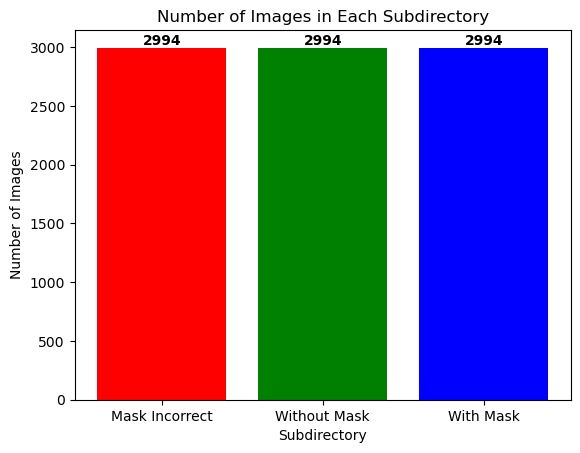

In [6]:
plt.bar(labels, counts, color = ['red', 'green', 'blue'])
plt.title('Number of Images in Each Subdirectory')
plt.xlabel('Subdirectory')
plt.ylabel('Number of Images')

for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom', fontweight='bold')

plt.show()

Thw plot shows us the distribution of data on those three classes are balanced. The three bars have an equal of data with 2994 data. A balanced dataset is ideal for making machine learning model because it ensures that the model is not biased towards any particular class. And since dataset is balanced, accuracy can be a good metric to evaluate the performance of the model as it measures the percentage of correct prediction made by the model.

## 4.2 - Data Shape

In [7]:
random_index = np.random.randint(0, len(mwi_glob)-1)

img_mwi = cv2.imread(mwi_glob[random_index])
img_wom = cv2.imread(wom_glob[random_index])
img_wim = cv2.imread(wim_glob[random_index])

print('Image in Mask Wear Incorrect shape:', img_mwi.shape)
print('Image in Without Mask shape:', img_wom.shape)
print('Image in With Mask shape:', img_wim.shape)

Image in Mask Wear Incorrect shape: (128, 128, 3)
Image in Without Mask shape: (128, 128, 3)
Image in With Mask shape: (128, 128, 3)


From the output we found that the shape of images from three different classes "Mask Wear Incorrect", "Without Mask", and "With Mask". All three images have the same shape of (128,128,3), which means that they are color images with three color channel - Red, Green, and Blue with height and width of 128 pixels each.

## 4.3 - Visualize Data

In [8]:
def random_sample(image_files, num_samples=5):
  random_files= random.sample(image_files, num_samples)
  return random_files

In [9]:
random_mwi = random_sample(mwi_glob)
random_wom = random_sample(wom_glob)
random_wim = random_sample(wim_glob)

In [10]:
def visualize_img(random_data, labels=None):
  fig, axes= plt.subplots(1,5, figsize=(15,12))
  for i, image_path in enumerate(random_data):
    image= plt.imread(image_path)
    axes[i].imshow(image) # bisa tanpa cmap kalau bener2 RGB
    axes[i].set_title(f'{labels}, {image.shape}')
    axes[i].axis('off')
  plt.show()

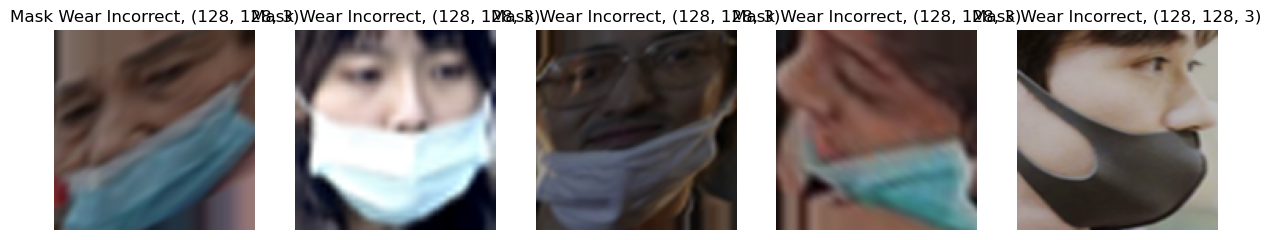

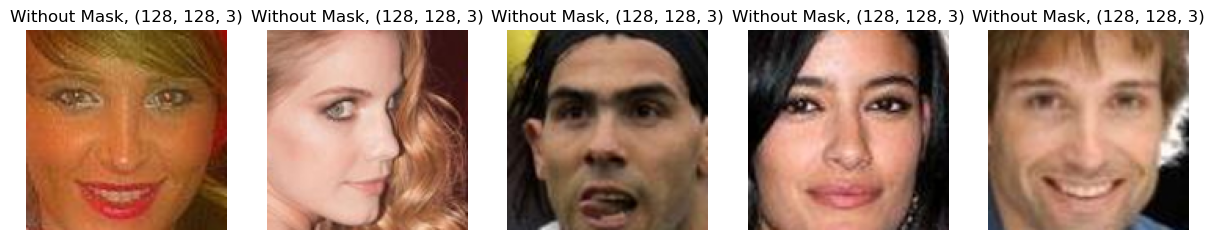

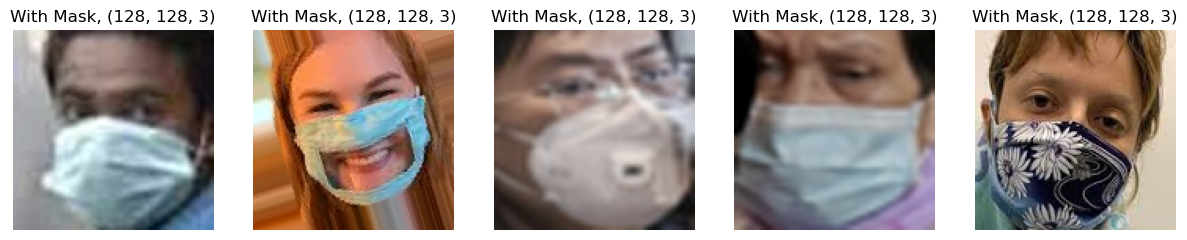

In [11]:
visualize_img(random_mwi, "Mask Wear Incorrect")
visualize_img(random_wom, "Without Mask")
visualize_img(random_wim, "With Mask")

The output provides insight on the characteristics of the images in the different classes, namely "Mask Wear Incorrect", "Without Mask", and "With Mask".

Mask Wear Incorrect:
- Mask visible in the images but show instances where the nose or mouth are not covered by the mask.

Without Mask:
- No mask is visible in the chin area
- No mask is visible at all

With Mask:

- The mask is covering both the mouth and nose
- Only the eyes are visible in the facial features

## 4.4 - Mean Image Classes

In [12]:
def find_mean_img(image_filenames):
    # create an empty list to store the images
    images = []
    
    # loop over the image filenames
    for filename in image_filenames:
        # read the image and resize it to a fixed size
        img = cv2.imread(filename)
        img = cv2.resize(img, (128, 128))
        
        # convert the image to a numpy array and add it to the list
        img = np.array(img, dtype=np.float32)
        images.append(img)
    
    # calculate the mean of the images along the first axis (the image index)
    mean_image = np.mean(images, axis=0)
    
    # convert the mean image back to unsigned 8-bit integer format
    mean_image = np.array(mean_image, dtype=np.uint8)
    
    return mean_image

In [13]:
mwi_mean = find_mean_img(mwi_glob)
wim_mean = find_mean_img(wim_glob)
wom_mean = find_mean_img(wom_glob)

Text(0.5, 1.0, 'Without mask')

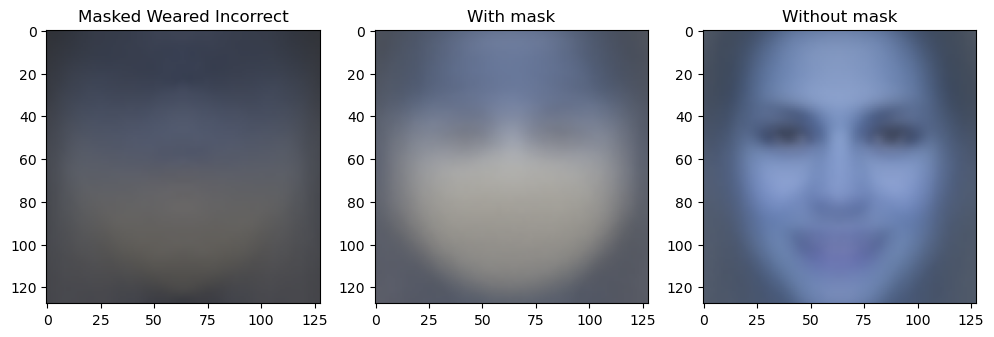

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))


ax[0].imshow(mwi_mean)
ax[0].set_title("Masked Weared Incorrect")

ax[1].imshow(wim_mean)
ax[1].set_title("With mask")

ax[2].imshow(wom_mean)
ax[2].set_title("Without mask")

From the plot, it can be observed that the three classes are quite different from one another. In the "Masked Weared Incorrect" class, although the image is blurry, it can be vaguely seen that the mask does not cover the nose. On the other hand, in the "With mask" class, although the image is also blurry, it can be vaguely seen that the mask must cover the nose to be detected as this class. Finally, in the "Without mask" class, which is different from the previous two classes, it is clear that the image does not show the person wearing a mask at all.

This insight can be useful in evaluating the performance of a mask detection model, as it highlights the differences between the different classes and the specific visual cues that need to be present for an image to be classified correctly. For example, the model may need to be trained to recognize the shape of the mask and its positioning on the face, as well as the absence of a mask altogether, in order to accurately detect whether a person is wearing a mask or not.

# 5 - Feature Engineering 📐

## 5.1 - Split Between X and y

In [15]:
img_paths = []
directories = ['Dataset/mask_weared_incorrect/', 
               'Dataset/with_mask/',
               'Dataset/without_mask/']

for folder in directories:
    for img_path in os.listdir(folder):
        if folder == 'Dataset/mask_weared_incorrect/':
            label = 'mask_weared_incorrect'
        elif folder == 'Dataset/with_mask/':
            label = 'with_mask'
        else:
            label = 'without_mask'

        img_paths.append([folder + img_path, label])

This code creates list that contains image and corresponding labels.

In [16]:
X = np.array([cv2.imread(img_path[0]) for img_path in img_paths]) / 255.0
y_label = np.array([label[1] for label in img_paths])

The code creates input feature and target label that required for machine learning model training.

For X variable it uses OpenCV to read all images in the directories and store the pixel values of the images in the numpy array X. After that we can normalize pixel value inside X by dividing it values by 255 or maximum heximal code. Dividing by 255.0 scales the pixel values down to the range of 0 to 1, which makes it easier for the model to learn and generalize patterns from the data. It also ensures that all images have the same scale, which is important for algorithms that are sensitive to the scale of the input data, such as neural networks.

The target labels for each image are extracted from the img_paths list and stored in the list y_label. The target labels represent the class of each image, which is either 'mask_weared_incorrect', 'with_mask', or 'without_mask'.

In [17]:
encoded_y = []
for label in y_label:
    # labels will be encoded as such: 0=mask_weared_incorrect, 1=with_mask, 2=without_mask
    if label == 'mask_weared_incorrect':
        encoded_y.append(0)
    elif label == 'with_mask':
        encoded_y.append(1)
    else:
        encoded_y.append(2)

y_encoded = np.array(encoded_y)
y = to_categorical(y=y_encoded, num_classes=3)

encoded_y is a variable that store label data that got encoded or change from string into numeric value.

y is a variable that store one hot encoder on labeling encoded_y. This variable also variable that we are going to use for training the data.

In [18]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Categorical labels shape: {y_label.shape}")
print(f"Encoded Categorical labels shape: {y_encoded.shape}")

X shape: (8982, 128, 128, 3)
y shape: (8982, 3)
Categorical labels shape: (8982,)
Encoded Categorical labels shape: (8982,)


## 5.2 - Split into Train-set, Validation-set and Test-set

In [19]:
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.333, random_state=42, shuffle=True)

print(f"\nTraining data: {X_train.shape},  labels: {y_train.shape}")
print(f"Validation data: {X_val.shape},  labels: {y_val.shape}")
print(f"Testing data: {X_test.shape},  labels: {y_test.shape}")


Training data: (6287, 128, 128, 3),  labels: (6287, 3)
Validation data: (1797, 128, 128, 3),  labels: (1797, 3)
Testing data: (898, 128, 128, 3),  labels: (898, 3)


Split data X and y into Train-set, Validation-set and Test-set. With Train-set 70%, Validation-set 20% and Test-set 10% data.

In [20]:
unique_rows, counts = np.unique(y_train, axis=0, return_counts=True)

print("Unique y_train rows:\n", unique_rows)
print("Counts:\n", counts)

unique_rows, counts = np.unique(y_val, axis=0, return_counts=True)

print("Unique y_val rows:\n", unique_rows)
print("Counts:\n", counts)

unique_rows, counts = np.unique(y_test, axis=0, return_counts=True)

print("Unique y_test rows:\n", unique_rows)
print("Counts:\n", counts)

Unique y_train rows:
 [[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]
Counts:
 [2104 2090 2093]
Unique y_val rows:
 [[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]
Counts:
 [610 592 595]
Unique y_test rows:
 [[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]
Counts:
 [280 312 306]


From the output we found that data already get spread. It can be proved when you look at the y_train, y_val and y_test unique values.

## 5.3 - Data Augmentation

In [21]:
def data_augmentation(image, label):
    # Apply random rotations, shifts, and flips to the image
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.5)
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    return image, label

function `data_augmentation` uses several common image data augmentation techniques to increase the diversity and size of training set:

- `image = tf.image.random_flip_left_right(image)`: This line applies a random horizontal flip to the image with a probability of 0.5.

- `image = tf.image.random_flip_up_down(image)`: This line applies a random vertical flip to the image with a probability of 0.5.

- `image = tf.image.random_brightness(image, max_delta=0.5)`: This line applies a random brightness adjustment to the image, where the maximum amount of brightness change is set to max_delta=0.5.

- `image = tf.image.random_contrast(image, lower=0.5, upper=1.5)`: This line applies a random contrast adjustment to the image, where the lower and upper bounds of the contrast change are set to lower=0.5 and upper=1.5, respectively.

- `image = tf.image.random_saturation(image, lower=0.5, upper=1.5)`: This line applies a random saturation adjustment to the image, where the lower and upper bounds of the saturation change are set to lower=0.5 and upper=1.5, respectively.

## 5.4 - Tensorflow Pipeline

### 5.4.1 - Pipeline With Data Augmentation

In [22]:
train_pipe_aug = tf.data.Dataset.from_tensor_slices((X_train, y_train)) # 1
train_pipe_aug = train_pipe_aug.map(data_augmentation) # 2
train_pipe_aug = train_pipe_aug.shuffle(buffer_size=len(y_train)) # 3
train_pipe_aug = train_pipe_aug.batch(batch_size=128) # 4
train_pipe_aug = train_pipe_aug.prefetch(buffer_size=tf.data.AUTOTUNE) # 5

The given code creates a TensorFlow data pipeline for the training data with data augmentation. Here's what each line of the code does:

1. Creates a TensorFlow dataset from Training-set where X_train is the training images and y_train is the labels.
2. This line applies the `data_augmentation` function to each image-label pair in the training dataset
3. This line shuffles the augmented training data randomly with a buffer size of len(y_train)
4. This line creates batches of size 128 from the shuffled augmented training data.
5. This line prefetches the next batch of data asynchronously while the current batch is being used for training, which can help to speed up training by reducing idle time.

### 5.4.2 - Pipeline Without Data Augmentation

In [23]:
train_pipe = tf.data.Dataset.from_tensor_slices((X_train,y_train)).shuffle(len(y_train)).batch(128).prefetch(tf.data.AUTOTUNE)
test_pipe = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(128)
val_pipe = tf.data.Dataset.from_tensor_slices((X_val,y_val)).batch(128)

This pipeline almost the same with Pipeline With Data Augmentation but the difference of these pipeline is that in this pipeline we are not use `data_augmentation` function.

And pipeline for Test-set and Val-set is just creates batches of size 128.

# 6 - First Model 🗃️

## 6.1 - First Model Without Aug

In [85]:
checkpoint_filepath_1 = 'best_model_1.h5'

checkpoint_callback_1 = ModelCheckpoint(
    filepath=checkpoint_filepath_1,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

Create a callback function that will be triggered during training model. Which saves the weights of the model to a file when the validation loss decreases, ensuring that the best performing version of the model is saved.

### 6.1.1 - Model Definition

In [86]:
# Clear Session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [87]:
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from keras.models import Model

input_dim = (128, 128, 3) # example input shape
num_classes = 3 # example number of classes

input_ = Input(shape=input_dim)

flatten_layer = Flatten()(input_)

dense_layer_1 = Dense(64, activation='relu')(flatten_layer)
dense_layer_2 = Dense(64, activation='relu')(dense_layer_1)
dense_layer_3 = Dense(64, activation='relu')(dense_layer_2)

output_layer = Dense(num_classes, activation='softmax')(dense_layer_3)

model_1 = Model(input_, output_layer)

model_1.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['Precision', 'accuracy'])
print(model_1.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 64)                3145792   
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 3,154,307
Trainable params: 3,154,307
Non-train

This code defines a neural network model with 3 fully connected layers, where each layer has 64 neurons with ReLU activation function. The input to the network is an image with shape (128, 128, 3), and the output is a probability distribution over 3 classes. The model is compiled with SGD(Stochastic Gradient Descent) optimizer, categorical cross-entropy loss function, and evaluation metrics of precision and accuracy.

### 6.1.2 - Model Training

Train model with train_pipe or pipeline without augmentation data.

In [88]:
%%time
# Train the Model
history_1 = model_1.fit(train_pipe, epochs=120, validation_data=val_pipe, callbacks=[checkpoint_callback_1])

Epoch 1/120
49/50 [============================>.] - ETA: 0s - loss: 0.9998 - precision: 0.5911 - accuracy: 0.4652
Epoch 1: val_loss improved from inf to 0.80522, saving model to best_model_1.h5
50/50 [==============================] - 3s 47ms/step - loss: 0.9992 - precision: 0.5919 - accuracy: 0.4659 - val_loss: 0.8052 - val_precision: 0.7739 - val_accuracy: 0.6672
Epoch 2/120
49/50 [============================>.] - ETA: 0s - loss: 0.7418 - precision: 0.7224 - accuracy: 0.6674
Epoch 2: val_loss improved from 0.80522 to 0.75184, saving model to best_model_1.h5
50/50 [==============================] - 2s 33ms/step - loss: 0.7420 - precision: 0.7227 - accuracy: 0.6676 - val_loss: 0.7518 - val_precision: 0.7412 - val_accuracy: 0.6923
Epoch 3/120
48/50 [===========================>..] - ETA: 0s - loss: 0.6347 - precision: 0.7703 - accuracy: 0.7381
Epoch 3: val_loss improved from 0.75184 to 0.68781, saving model to best_model_1.h5
50/50 [==============================] - 2s 32ms/step - los

Save the model so that the results do not change when we try to reevaluate the model. Convert trainable params into Non-trainable params and then save the model.

In [133]:
model_1.trainable = False
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 64)                3145792   
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 3,154,307
Trainable params: 0
Non-trainable par

In [130]:
# Save Model
# model_1.save('load_model_1.h5')

### 6.1.3 - Model Evaluation

In [89]:
history_1_df = pd.DataFrame(history_1.history)
history_1_df

loss  precision  accuracy  val_loss  val_precision  val_accuracy
0    0.999175   0.591930  0.465882  0.805218       0.773925      0.667223
1    0.741950   0.722749  0.667568  0.751844       0.741240      0.692265
2    0.634483   0.772120  0.739144  0.687808       0.725235      0.653868
3    0.588054   0.789809  0.762367  0.552525       0.795455      0.778520
4    0.532516   0.824084  0.799427  0.599825       0.764112      0.751252
..        ...        ...       ...       ...            ...           ...
115  0.126579   0.961938  0.959122  0.142858       0.955792      0.951586
116  0.071889   0.980233  0.979641  0.289001       0.907199      0.900946
117  0.063596   0.981662  0.980118  0.558205       0.846927      0.844741
118  0.095546   0.971766  0.970097  0.128010       0.959844      0.957707
119  0.060006   0.981204  0.980595  0.117562       0.961517      0.959933

[120 rows x 6 columns]

<AxesSubplot:>

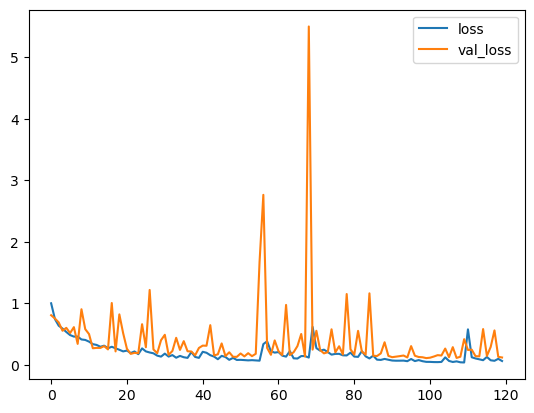

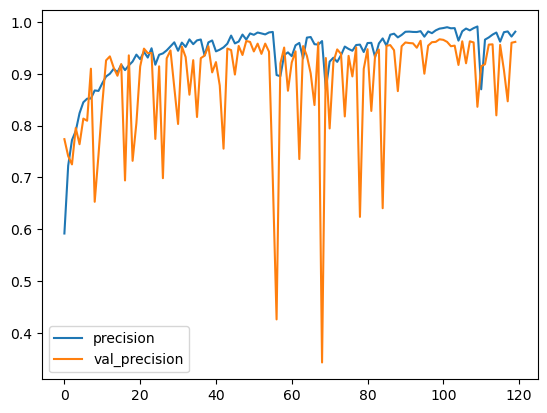

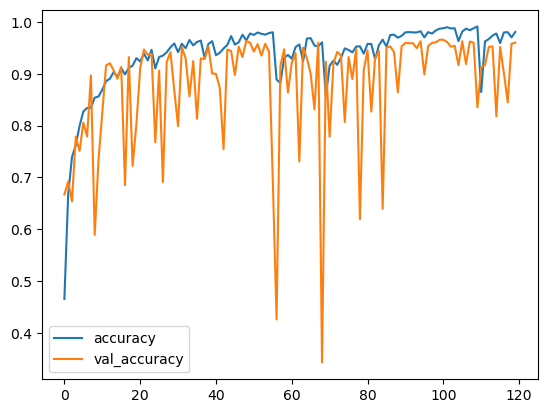

In [90]:
history_1_df[['loss', 'val_loss']].plot()
history_1_df[['precision', 'val_precision']].plot()
history_1_df[['accuracy', 'val_accuracy']].plot()

#### 6.1.3.1 - Evaluation model all epochs

Load model that have been saved with after finishing training

In [24]:
load_model_1 = load_model("load_model_1.h5")

In [73]:
print(classification_report(y_test.argmax(axis = 1), load_model_1.predict(X_test).argmax(axis = 1)))
print("")
print("Accuracy score Train-set on load_model_1 : ", accuracy_score(y_train.argmax(axis = 1), load_model_1.predict(X_train).argmax(axis = 1)))
print("Accuracy score Test-set on load_model_1 : ", accuracy_score(y_test.argmax(axis = 1), load_model_1.predict(X_test).argmax(axis = 1)))
print("")
print("Precision score Train-set on load_model_1 : ", precision_score(y_train.argmax(axis = 1), load_model_1.predict(X_train).argmax(axis = 1), average='weighted'))
print("Precision score Test-set on load_model_1 : ", precision_score(y_test.argmax(axis = 1), load_model_1.predict(X_test).argmax(axis = 1), average='weighted'))
print("")
print("Recall score Train-set on load_model_1 : ", recall_score(y_train.argmax(axis = 1), load_model_1.predict(X_train).argmax(axis = 1), average='weighted'))
print("Recall score Test-set on load_model_1 : ", recall_score(y_test.argmax(axis = 1), load_model_1.predict(X_test).argmax(axis = 1), average='weighted'))

29/29 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       306
           1       0.98      0.90      0.94       312
           2       0.93      0.97      0.95       280

    accuracy                           0.95       898
   macro avg       0.95      0.95      0.95       898
weighted avg       0.95      0.95      0.95       898


197/197 [==============================] - 1s 3ms/step
Accuracy score Train-set on load_model_1 :  0.9890249721647845
29/29 [==============================] - 0s 3ms/step
Accuracy score Test-set on load_model_1 :  0.9532293986636972

197/197 [==============================] - 1s 3ms/step
Precision score Train-set on load_model_1 :  0.9890260587093608
29/29 [==============================] - 0s 3ms/step
Precision score Test-set on load_model_1 :  0.9541056985998226

197/197 [==============================] - 1s 3ms/step
Precision score Train-set on load_model_

The model shows accuracy, precision, and recall scores above 90% on both train and test sets, indicating that it is highly effective in detecting 'mask_weared_incorrect', 'with_mask', and 'without_mask' classes in face images. These results suggest that the model could be reliable for detecting face masks in real-world scenarios.

29/29 [==============================] - 0s 3ms/step


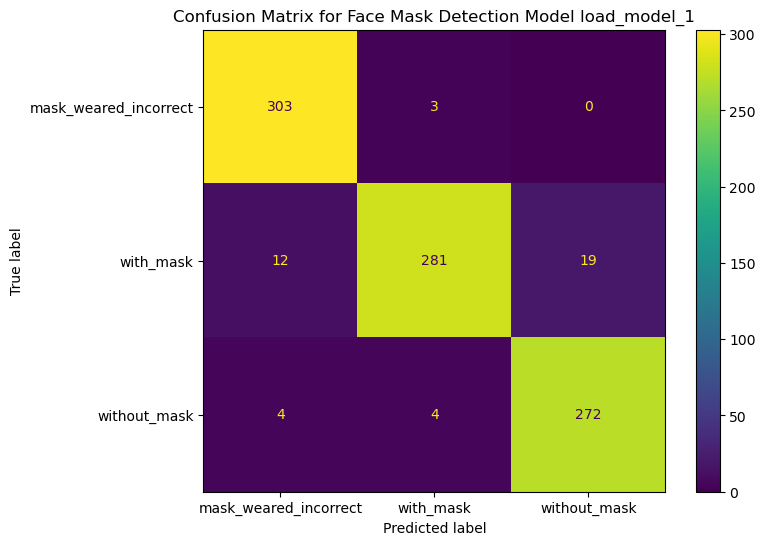

In [82]:
# Calculate confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), load_model_1.predict(X_test).argmax(axis=1))

# Create confusion matrix display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['mask_weared_incorrect', 'with_mask', 'without_mask'])

# Set size and add title to plot
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)
ax.set_title('Confusion Matrix for Face Mask Detection Model load_model_1')

plt.show()

For the 'mask_weared_incorrect' class, the model has correctly classified 303 samples and misclassified only 3 samples as 'with_mask'. For the 'with_mask' class, the model has correctly classified 281 samples and misclassified 12 samples as 'mask_weared_incorrect' and 19 samples as 'without_mask'. For the 'without_mask' class, the model has correctly classified 272 samples and misclassified 4 samples as 'mask_weared_incorrect' and 4 samples as 'with_mask'.

#### 6.1.3.2 - Evaluation model callback

Load model that have been saved with callback ModelCheckpoint.

In [27]:
best_load_model_1 = load_model("best_model_1.h5")

In [74]:
print(classification_report(y_test.argmax(axis = 1), best_load_model_1.predict(X_test).argmax(axis = 1)))
print("")
print("Accuracy score Train-set on best_load_model_1 : ", accuracy_score(y_train.argmax(axis = 1), best_load_model_1.predict(X_train).argmax(axis = 1)))
print("Accuracy score Test-set on best_load_model_1 : ", accuracy_score(y_test.argmax(axis = 1), best_load_model_1.predict(X_test).argmax(axis = 1)))
print("")
print("Precision score Train-set on best_load_model_1 : ", precision_score(y_train.argmax(axis = 1), best_load_model_1.predict(X_train).argmax(axis = 1), average='weighted'))
print("Precision score Test-set on best_load_model_1 : ", precision_score(y_test.argmax(axis = 1), best_load_model_1.predict(X_test).argmax(axis = 1), average='weighted'))
print("")
print("Recall score Train-set on load_model_1 : ", recall_score(y_train.argmax(axis = 1), best_load_model_1.predict(X_train).argmax(axis = 1), average='weighted'))
print("Recall score Test-set on load_model_1 : ", recall_score(y_test.argmax(axis = 1), best_load_model_1.predict(X_test).argmax(axis = 1), average='weighted'))

29/29 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       306
           1       0.98      0.90      0.94       312
           2       0.94      0.98      0.96       280

    accuracy                           0.96       898
   macro avg       0.96      0.96      0.96       898
weighted avg       0.96      0.96      0.96       898


197/197 [==============================] - 1s 3ms/step
Accuracy score Train-set on best_load_model_1 :  0.9906155559090186
29/29 [==============================] - 0s 3ms/step
Accuracy score Test-set on best_load_model_1 :  0.9576837416481069

197/197 [==============================] - 1s 4ms/step
Precision score Train-set on best_load_model_1 :  0.9906684699493664
29/29 [==============================] - 0s 3ms/step
Precision score Test-set on best_load_model_1 :  0.9585232705459982

197/197 [==============================] - 1s 3ms/step
Recall score Train-s

The model shows accuracy, precision, and recall scores above 90% on both train and test sets, indicating that it is highly effective in detecting 'mask_weared_incorrect', 'with_mask', and 'without_mask' classes in face images. These results suggest that the model could be reliable for detecting face masks in real-world scenarios. Additionally, the model appears to be better than a model that does not use the callback ModelCheckpoint, as it can save the best model during training and prevent overfitting.

29/29 [==============================] - 0s 3ms/step


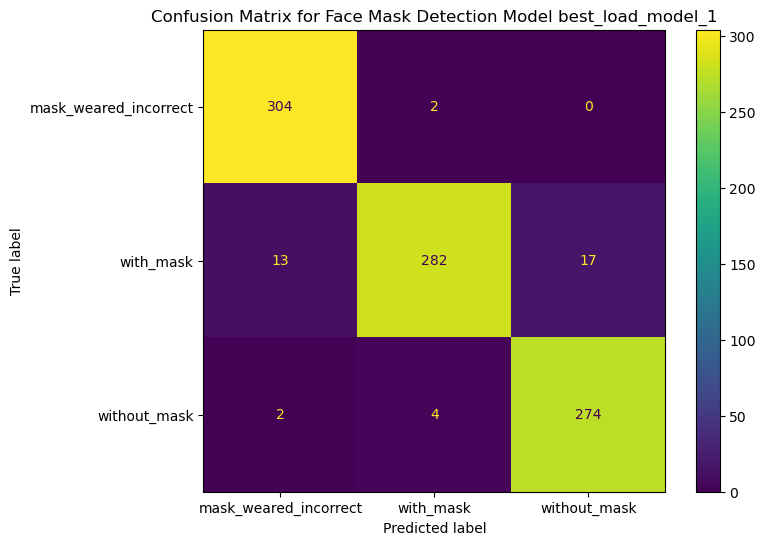

In [84]:
# Calculate confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), best_load_model_1.predict(X_test).argmax(axis=1))

# Create confusion matrix display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['mask_weared_incorrect', 'with_mask', 'without_mask'])

# Set size and add title to plot
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)
ax.set_title('Confusion Matrix for Face Mask Detection Model best_load_model_1')

plt.show()

For the 'mask_weared_incorrect' class, the model has correctly classified 304 samples and misclassified only 2 samples as 'with_mask'. For the 'with_mask' class, the model has correctly classified 282 samples and misclassified 13 samples as 'mask_weared_incorrect' and 17 samples as 'without_mask'. For the 'without_mask' class, the model has correctly classified 274 samples and misclassified 2 samples as 'mask_weared_incorrect' and 4 samples as 'with_mask'.

## 6.2 - First Model Aug

In [92]:
checkpoint_filepath_1_aug = 'best_model_1_aug.h5'

checkpoint_callback_1_aug = ModelCheckpoint(
    filepath=checkpoint_filepath_1_aug,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

Create a callback function that will be triggered during training model. Which saves the weights of the model to a file when the validation loss decreases, ensuring that the best performing version of the model is saved.

### 6.2.1 - Model Definition

In [93]:
# Clear Session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [94]:
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from keras.models import Model

input_dim = (128, 128, 3) # example input shape
num_classes = 3 # example number of classes

input_ = Input(shape=input_dim)

flatten_layer = Flatten()(input_)

dense_layer_1 = Dense(64, activation='relu')(flatten_layer)
dense_layer_2 = Dense(64, activation='relu')(dense_layer_1)
dense_layer_3 = Dense(64, activation='relu')(dense_layer_2)

output_layer = Dense(num_classes, activation='softmax')(dense_layer_3)

model_1_aug = Model(input_, output_layer)

model_1_aug.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['Precision', 'accuracy'])
print(model_1_aug.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 64)                3145792   
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 3,154,307
Trainable params: 3,154,307
Non-train

This code defines a neural network model with 3 fully connected layers, where each layer has 64 neurons with ReLU activation function. The input to the network is an image with shape (128, 128, 3), and the output is a probability distribution over 3 classes. The model is compiled with SGD(Stochastic Gradient Descent) optimizer, categorical cross-entropy loss function, and evaluation metrics of precision and accuracy.

### 6.2.2 - Model Training

Train model with train_pipe_aug or pipeline with augmentation data.

In [ ]:
%%time
# Train the Model
history_1_aug = model_1_aug.fit(train_pipe_aug, epochs=120, validation_data=val_pipe, callbacks=[checkpoint_callback_1_aug])

Save the model so that the results do not change when we try to reevaluate the model. Convert trainable params into Non-trainable params and then save the model.

In [124]:
model_1_aug.trainable = False
model_1_aug.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 64)                3145792   
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 3,154,307
Trainable params: 0
Non-trainable par

In [129]:
# Save Model
#model_1_aug.save('load_model_1_aug.h5')

### 6.2.3 - Model Evaluation

In [96]:
history_1_aug_df = pd.DataFrame(history_1_aug.history)
history_1_aug_df

loss  precision  accuracy  val_loss  val_precision  val_accuracy
0    1.029916   0.600165  0.475107  1.080552       0.455285      0.469115
1    0.903568   0.689966  0.574837  1.064418       0.367398      0.341681
2    0.820498   0.702965  0.631621  0.722052       0.811282      0.740122
3    0.728413   0.745875  0.683474  0.704902       0.774447      0.739566
4    0.693566   0.751076  0.699857  0.646921       0.758290      0.702838
..        ...        ...       ...       ...            ...           ...
115  0.193361   0.935437  0.932082  0.157842       0.947427      0.945465
116  0.175002   0.944516  0.940035  0.384876       0.869095      0.860323
117  0.167398   0.945282  0.941626  1.138798       0.702053      0.683918
118  0.376369   0.896138  0.887546  0.134286       0.958147      0.957151
119  0.210096   0.925729  0.918880  0.168197       0.944009      0.941569

[120 rows x 6 columns]

<AxesSubplot:>

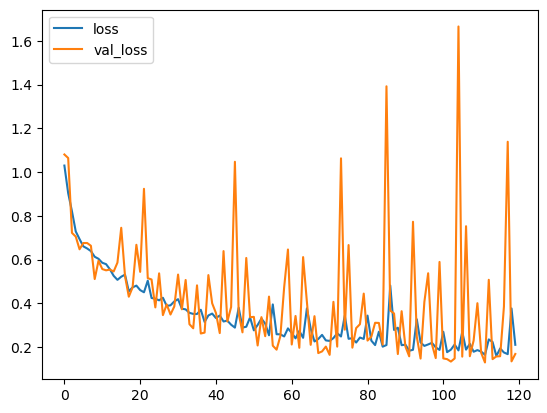

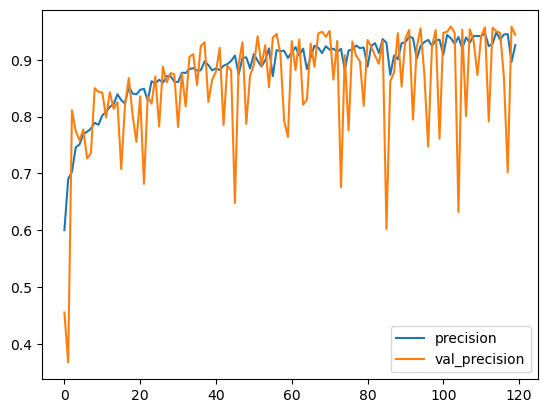

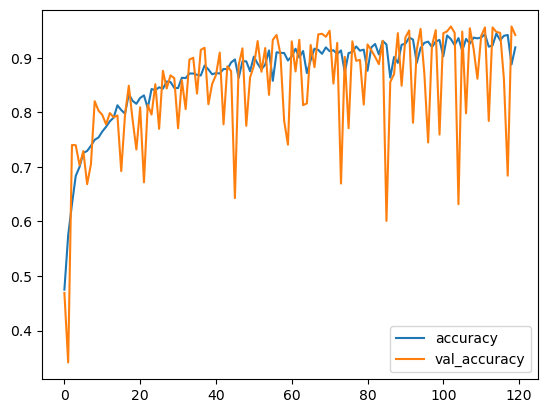

In [97]:
history_1_aug_df[['loss', 'val_loss']].plot()
history_1_aug_df[['precision', 'val_precision']].plot()
history_1_aug_df[['accuracy', 'val_accuracy']].plot()

#### 6.2.3.1 - Evaluation model all epochs

Load model that have been saved with after finishing training

In [41]:
load_model_1_aug = load_model("load_model_1_aug.h5")

In [75]:
print(classification_report(y_test.argmax(axis = 1), load_model_1_aug.predict(X_test).argmax(axis = 1)))
print("")
print("Accuracy score Train-set on load_model_1_aug : ", accuracy_score(y_train.argmax(axis = 1), load_model_1_aug.predict(X_train).argmax(axis = 1)))
print("Accuracy score Test-set on load_model_1_aug : ", accuracy_score(y_test.argmax(axis = 1), load_model_1_aug.predict(X_test).argmax(axis = 1)))
print("")
print("Precision score Train-set on load_model_1_aug : ", precision_score(y_train.argmax(axis = 1), load_model_1_aug.predict(X_train).argmax(axis = 1), average='weighted'))
print("Precision score Test-set on load_model_1_aug : ", precision_score(y_test.argmax(axis = 1), load_model_1_aug.predict(X_test).argmax(axis = 1), average='weighted'))
print("")
print("Recall score Train-set on load_model_1 : ", recall_score(y_train.argmax(axis = 1), load_model_1_aug.predict(X_train).argmax(axis = 1), average='weighted'))
print("Recall score Test-set on load_model_1 : ", recall_score(y_test.argmax(axis = 1), load_model_1_aug.predict(X_test).argmax(axis = 1), average='weighted'))

29/29 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       306
           1       0.98      0.88      0.93       312
           2       0.91      0.97      0.94       280

    accuracy                           0.94       898
   macro avg       0.94      0.94      0.94       898
weighted avg       0.94      0.94      0.94       898


197/197 [==============================] - 1s 3ms/step
Accuracy score Train-set on load_model_1_aug :  0.9484650866868141
29/29 [==============================] - 0s 3ms/step
Accuracy score Test-set on load_model_1_aug :  0.9420935412026726

197/197 [==============================] - 1s 3ms/step
Precision score Train-set on load_model_1_aug :  0.9489248213597461
29/29 [==============================] - 0s 3ms/step
Precision score Test-set on load_model_1_aug :  0.9440347944831657

197/197 [==============================] - 1s 3ms/step
Recall score Train-set o

The model shows accuracy, precision, and recall scores above 90% on both train and test sets, indicating that it is highly effective in detecting 'mask_weared_incorrect', 'with_mask', and 'without_mask' classes in face images. These results suggest that the model could be reliable for detecting face masks in real-world scenarios.

29/29 [==============================] - 0s 3ms/step


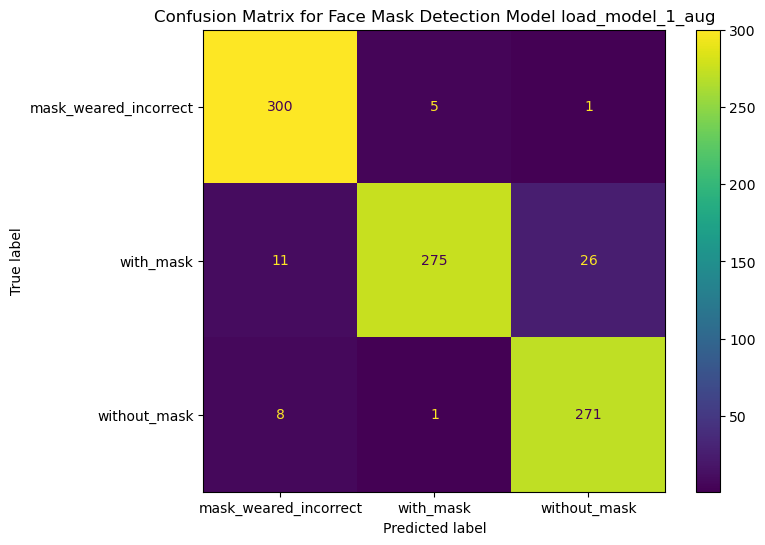

In [86]:
# Calculate confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), load_model_1_aug.predict(X_test).argmax(axis=1))

# Create confusion matrix display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['mask_weared_incorrect', 'with_mask', 'without_mask'])

# Set size and add title to plot
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)
ax.set_title('Confusion Matrix for Face Mask Detection Model load_model_1_aug')

plt.show()

For the 'mask_weared_incorrect' class, the model has correctly classified 300 samples and misclassified 5 samples as 'with_mask' and 1 sample as 'without_mask'. For the 'with_mask' class, the model has correctly classified 275 samples and misclassified 11 samples as 'mask_weared_incorrect' and 26 samples as 'without_mask'. For the 'without_mask' class, the model has correctly classified 271 samples and misclassified 8 samples as 'mask_weared_incorrect' and 1 sample as 'with_mask'.

#### 6.2.3.2 - Evaluation model callback

Load model that have been saved with callback ModelCheckpoint.

In [44]:
best_load_model_1_aug = load_model("best_model_1_aug.h5")

In [76]:
print(classification_report(y_test.argmax(axis = 1), best_load_model_1_aug.predict(X_test).argmax(axis = 1)))
print("")
print("Accuracy score Train-set on best_load_model_1_aug : ", accuracy_score(y_train.argmax(axis = 1), best_load_model_1_aug.predict(X_train).argmax(axis = 1)))
print("Accuracy score Test-set on best_load_model_1_aug : ", accuracy_score(y_test.argmax(axis = 1), best_load_model_1_aug.predict(X_test).argmax(axis = 1)))
print("")
print("Precision score Train-set on best_load_model_1_aug : ", precision_score(y_train.argmax(axis = 1), best_load_model_1_aug.predict(X_train).argmax(axis = 1), average='weighted'))
print("Precision score Test-set on best_load_model_1_aug : ", precision_score(y_test.argmax(axis = 1), best_load_model_1_aug.predict(X_test).argmax(axis = 1), average='weighted'))
print("")
print("Recall score Train-set on load_model_1 : ", recall_score(y_train.argmax(axis = 1), best_load_model_1_aug.predict(X_train).argmax(axis = 1), average='weighted'))
print("Recall score Test-set on load_model_1 : ", recall_score(y_test.argmax(axis = 1), best_load_model_1_aug.predict(X_test).argmax(axis = 1), average='weighted'))

29/29 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       306
           1       0.99      0.86      0.92       312
           2       0.91      0.98      0.94       280

    accuracy                           0.95       898
   macro avg       0.95      0.95      0.94       898
weighted avg       0.95      0.95      0.94       898


197/197 [==============================] - 1s 3ms/step
Accuracy score Train-set on best_load_model_1_aug :  0.9648480992524257
29/29 [==============================] - 0s 3ms/step
Accuracy score Test-set on best_load_model_1_aug :  0.9454342984409799

197/197 [==============================] - 1s 3ms/step
Precision score Train-set on best_load_model_1_aug :  0.9658932806455947
29/29 [==============================] - 0s 3ms/step
Precision score Test-set on best_load_model_1_aug :  0.9484092850807447

197/197 [==============================] - 1s 3ms/step
Reca

The model shows accuracy, precision, and recall scores above 90% on both train and test sets, indicating that it is highly effective in detecting 'mask_weared_incorrect', 'with_mask', and 'without_mask' classes in face images. These results suggest that the model could be reliable for detecting face masks in real-world scenarios. Additionally, the model appears to be better than a model that does not use the callback ModelCheckpoint, as it can save the best model during training and prevent overfitting.

29/29 [==============================] - 0s 3ms/step


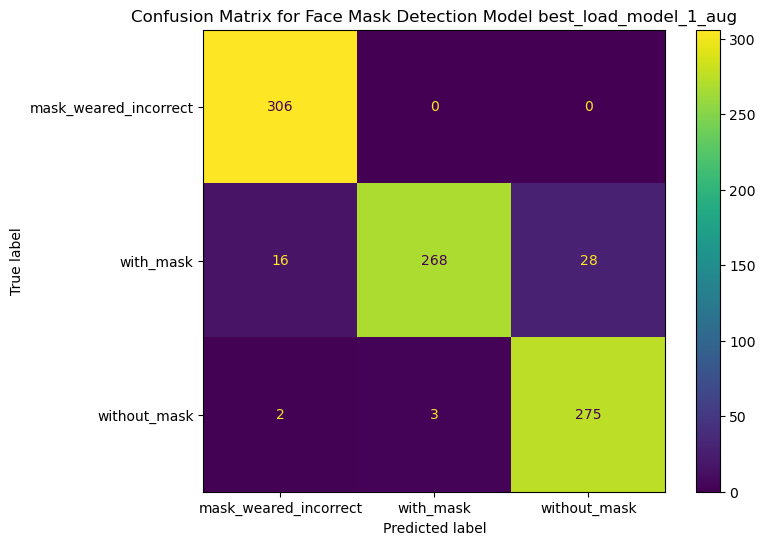

In [88]:
# Calculate confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), best_load_model_1_aug.predict(X_test).argmax(axis=1))

# Create confusion matrix display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['mask_weared_incorrect', 'with_mask', 'without_mask'])

# Set size and add title to plot
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)
ax.set_title('Confusion Matrix for Face Mask Detection Model best_load_model_1_aug')

plt.show()

This confusion matrix shows that the model has accurately classified all samples for the 'mask_weared_incorrect' class. For the 'with_mask' class, the model has correctly classified 268 samples, but misclassified 16 samples as 'mask_weared_incorrect' and 28 samples as 'without_mask'. For the 'without_mask' class, the model has correctly classified 275 samples, but misclassified 4 samples as 'mask_weared_incorrect' and 3 samples as 'with_mask'. Overall, the model appears to be effective in detecting face masks, but there is still room for improvement in correctly classifying images of faces with and without masks.

# 7 - Model Improvement 🗃️

## 7.1 Model Improvement Without Aug

In [103]:
checkpoint_filepath_imp = 'best_model_imp.h5'

checkpoint_callback_imp = ModelCheckpoint(
    filepath=checkpoint_filepath_imp,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

Create a callback function that will be triggered during training model. Which saves the weights of the model to a file when the validation loss decreases, ensuring that the best performing version of the model is saved.

### 7.1.1 - Model Definition

In [104]:
# Clear Session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [105]:
input_dim = (128, 128, 3)
num_classes = 3
input_ = Input(shape=input_dim)

flatten_layer = Flatten()(input_)

hidden_layer_1 = Conv2D(64, kernel_size=(2, 2), padding='same', activation='relu')(input_)
hidden_layer_1 = MaxPooling2D(pool_size=(2, 2))(hidden_layer_1)
hidden_layer_1 = BatchNormalization()(hidden_layer_1)

hidden_layer_2 = Conv2D(64, kernel_size=(2, 2), padding='same', activation='relu')(hidden_layer_1)
hidden_layer_2 = MaxPooling2D(pool_size=(2, 2))(hidden_layer_2)
hidden_layer_2 = BatchNormalization()(hidden_layer_2)
hidden_layer_2 = Dropout(0.5)(hidden_layer_2)

dense_layer_1 = Dense(64, activation='relu')(flatten_layer)
dense_layer_2 = Dense(64, activation='relu')(dense_layer_1)
dense_layer_3 = Dense(64, activation='relu')(dense_layer_2)

output_layer = Dense(num_classes, activation='softmax')(dense_layer_3)

model_imp = Model(input_, output_layer)

opt = SGD(lr=0.01, clipnorm=1.0)

model_imp.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['Precision', 'accuracy'])

print(model_imp.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 64)                3145792   
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 3,154,307
Trainable params: 3,154,307
Non-train

This code defines a convolutional neural network model that takes an input image of shape (128, 128, 3) and predicts a probability distribution over 3 classes. The model consists of two convolutional layers with 64 filters, each followed by a max-pooling layer, batch normalization, and dropout. These layers are then connected to three fully connected layers with 64 neurons and ReLU activation. The model is compiled with stochastic gradient descent optimizer with a learning rate of 0.01 and a clipnorm of 1.0, categorical cross-entropy loss function, and evaluation metrics of precision and accuracy.

### 7.1.2 - Model Training

Train model with train_pipe or pipeline without augmentation data.

In [106]:
%%time
# Train the Model
history_imp = model_imp.fit(train_pipe, epochs=120, validation_data=val_pipe, callbacks=[checkpoint_callback_imp])

Epoch 1/120
49/50 [============================>.] - ETA: 0s - loss: 0.8655 - precision: 0.7743 - accuracy: 0.5454
Epoch 1: val_loss improved from inf to 0.88674, saving model to best_model_imp.h5
50/50 [==============================] - 2s 34ms/step - loss: 0.8647 - precision: 0.7745 - accuracy: 0.5462 - val_loss: 0.8867 - val_precision: 0.5193 - val_accuracy: 0.4847
Epoch 2/120
49/50 [============================>.] - ETA: 0s - loss: 0.6820 - precision: 0.7719 - accuracy: 0.7057
Epoch 2: val_loss improved from 0.88674 to 0.62983, saving model to best_model_imp.h5
50/50 [==============================] - 2s 32ms/step - loss: 0.6817 - precision: 0.7723 - accuracy: 0.7059 - val_loss: 0.6298 - val_precision: 0.8207 - val_accuracy: 0.7663
Epoch 3/120
50/50 [==============================] - ETA: 0s - loss: 0.5892 - precision: 0.8124 - accuracy: 0.7710
Epoch 3: val_loss improved from 0.62983 to 0.52209, saving model to best_model_imp.h5
50/50 [==============================] - 2s 32ms/step

Save the model so that the results do not change when we try to reevaluate the model. Convert trainable params into Non-trainable params and then save the model.

In [126]:
model_imp.trainable = False
model_imp.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 64)                3145792   
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 3,154,307
Trainable params: 0
Non-trainable par

In [131]:
# Save Model
# model_imp.save('load_model_imp.h5')

### 7.1.3 - Model Evaluation

In [107]:
history_imp_df = pd.DataFrame(history_imp.history)
history_imp_df

loss  precision  accuracy  val_loss  val_precision  val_accuracy
0    0.864662   0.774531  0.546206  0.886744       0.519330      0.484697
1    0.681744   0.772348  0.705901  0.629829       0.820652      0.766277
2    0.589163   0.812355  0.770956  0.522089       0.864950      0.831386
3    0.535344   0.831049  0.798314  0.554176       0.842345      0.812465
4    0.489143   0.845174  0.819946  0.434770       0.896797      0.872565
..        ...        ...       ...       ...            ...           ...
115  0.020906   0.993320  0.993320  0.141289       0.959331      0.958264
116  0.018647   0.995546  0.995546  0.127786       0.964365      0.963829
117  0.019615   0.995862  0.995387  0.115887       0.966017      0.966055
118  0.019512   0.995067  0.994910  0.206111       0.948218      0.947691
119  0.019906   0.995545  0.995546  0.139756       0.958820      0.958820

[120 rows x 6 columns]

<AxesSubplot:>

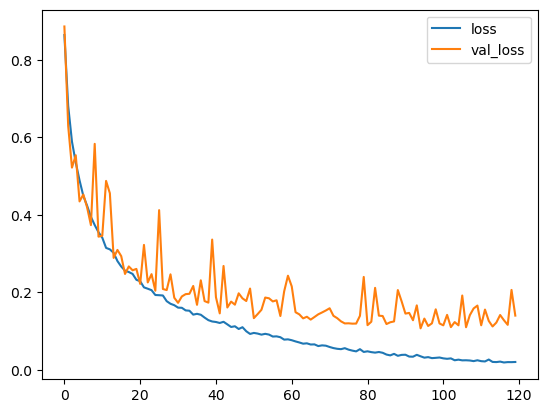

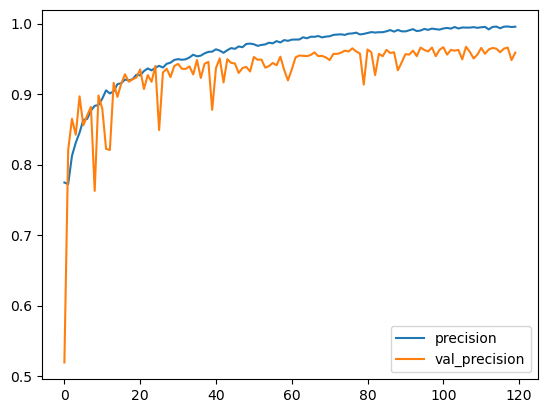

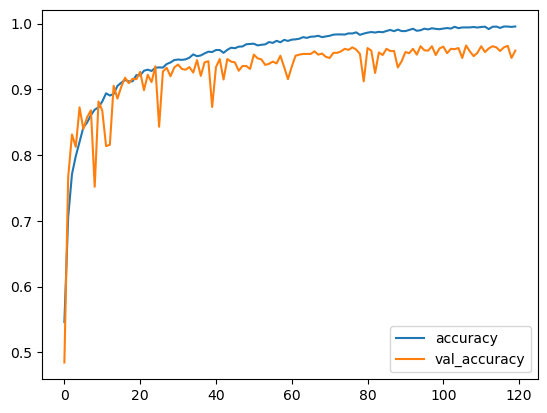

In [108]:
history_imp_df[['loss', 'val_loss']].plot()
history_imp_df[['precision', 'val_precision']].plot()
history_imp_df[['accuracy', 'val_accuracy']].plot()

#### 7.1.3.1 - Evaluation model all epochs

Load model that have been saved with after finishing training

In [48]:
load_model_imp = load_model("load_model_imp.h5")

In [77]:
print(classification_report(y_test.argmax(axis = 1), load_model_imp.predict(X_test).argmax(axis = 1)))
print("")
print("Accuracy score Train-set on load_model_imp : ", accuracy_score(y_train.argmax(axis = 1), load_model_imp.predict(X_train).argmax(axis = 1)))
print("Accuracy score Test-set on load_model_imp : ", accuracy_score(y_test.argmax(axis = 1), load_model_imp.predict(X_test).argmax(axis = 1)))
print("")
print("Precision score Train-set on load_model_imp : ", precision_score(y_train.argmax(axis = 1), load_model_imp.predict(X_train).argmax(axis = 1), average='weighted'))
print("Precision score Test-set on load_model_imp : ", precision_score(y_test.argmax(axis = 1), load_model_imp.predict(X_test).argmax(axis = 1), average='weighted'))
print("")
print("Recall score Train-set on load_model_1 : ", recall_score(y_train.argmax(axis = 1), load_model_imp.predict(X_train).argmax(axis = 1), average='weighted'))
print("Recall score Test-set on load_model_1 : ", recall_score(y_test.argmax(axis = 1), load_model_imp.predict(X_test).argmax(axis = 1), average='weighted'))

29/29 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       306
           1       0.97      0.91      0.94       312
           2       0.97      0.96      0.97       280

    accuracy                           0.96       898
   macro avg       0.96      0.96      0.96       898
weighted avg       0.96      0.96      0.96       898


197/197 [==============================] - 1s 3ms/step
Accuracy score Train-set on load_model_imp :  0.994592015269604
29/29 [==============================] - 0s 3ms/step
Accuracy score Test-set on load_model_imp :  0.9576837416481069

197/197 [==============================] - 1s 3ms/step
Precision score Train-set on load_model_imp :  0.9946119028809635
29/29 [==============================] - 0s 3ms/step
Precision score Test-set on load_model_imp :  0.9585048041900981

197/197 [==============================] - 1s 4ms/step
Recall score Train-set on load_mo

The model shows accuracy, precision, and recall scores above 95% on both train and test sets, indicating that it is highly effective in detecting 'mask_weared_incorrect', 'with_mask', and 'without_mask' classes in face images. These results suggest that the model could be reliable for detecting face masks in real-world scenarios. It is worth noting that the improved model's performance surpasses the previous model's performance by a significant margin. This improvement highlights the importance of ongoing refinement and optimization in machine learning models, ultimately leading to more accurate and reliable results. As such, the improved model may be better suited for real-world applications, where high levels of accuracy are crucial.

29/29 [==============================] - 0s 3ms/step


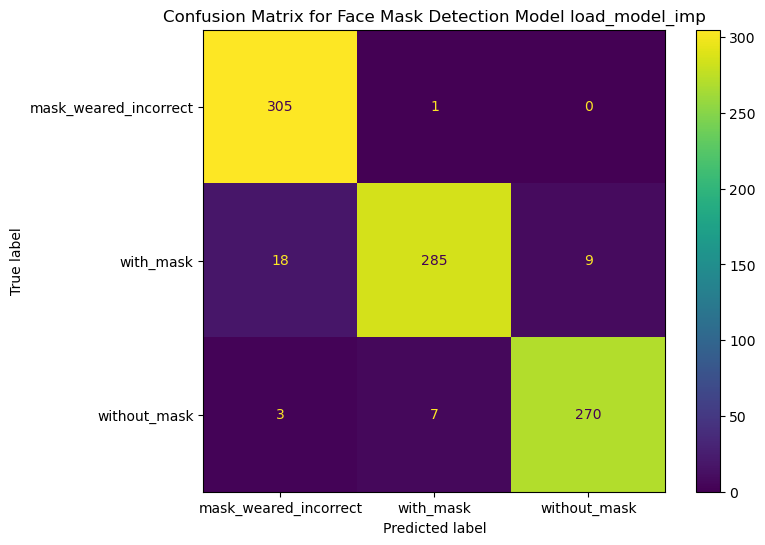

In [90]:
# Calculate confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), load_model_imp.predict(X_test).argmax(axis=1))

# Create confusion matrix display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['mask_weared_incorrect', 'with_mask', 'without_mask'])

# Set size and add title to plot
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)
ax.set_title('Confusion Matrix for Face Mask Detection Model load_model_imp')

plt.show()

This confusion matrix shows that the model has correctly classified a majority of the samples across all three classes. For the 'mask_weared_incorrect' class, the model has correctly classified 305 samples and misclassified only 1 sample as 'with_mask'. For the 'with_mask' class, the model has correctly classified 285 samples and misclassified 18 samples as 'mask_weared_incorrect' and 9 samples as 'without_mask'. For the 'without_mask' class, the model has correctly classified 270 samples and misclassified 3 samples as 'mask_weared_incorrect' and 7 samples as 'with_mask'. Overall, this improved model performs much better than the first model or the model before the improvement.

#### 7.1.3.2 - Evaluation model callback

Load model that have been saved with callback ModelCheckpoint.

In [51]:
best_load_model_imp = load_model("best_model_imp.h5")

In [79]:
print(classification_report(y_test.argmax(axis = 1), best_load_model_imp.predict(X_test).argmax(axis = 1)))
print("")
print("Accuracy score Train-set on best_load_model_1 : ", accuracy_score(y_train.argmax(axis = 1), best_load_model_imp.predict(X_train).argmax(axis = 1)))
print("Accuracy score Test-set on best_load_model_1 : ", accuracy_score(y_test.argmax(axis = 1), best_load_model_imp.predict(X_test).argmax(axis = 1)))
print("")
print("Precision score Train-set on best_load_model_1 : ", precision_score(y_train.argmax(axis = 1), best_load_model_imp.predict(X_train).argmax(axis = 1), average='weighted'))
print("Precision score Test-set on best_load_model_1 : ", precision_score(y_test.argmax(axis = 1), best_load_model_imp.predict(X_test).argmax(axis = 1), average='weighted'))
print("")
print("Recall score Train-set on load_model_1 : ", recall_score(y_train.argmax(axis = 1), best_load_model_imp.predict(X_train).argmax(axis = 1), average='weighted'))
print("Recall score Test-set on load_model_1 : ", recall_score(y_test.argmax(axis = 1), best_load_model_imp.predict(X_test).argmax(axis = 1), average='weighted'))

29/29 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       306
           1       0.98      0.91      0.94       312
           2       0.94      0.99      0.96       280

    accuracy                           0.96       898
   macro avg       0.96      0.96      0.96       898
weighted avg       0.96      0.96      0.96       898


197/197 [==============================] - 1s 3ms/step
Accuracy score Train-set on best_load_model_1 :  0.9961825990138381
29/29 [==============================] - 0s 3ms/step
Accuracy score Test-set on best_load_model_1 :  0.9610244988864143

197/197 [==============================] - 1s 3ms/step
Precision score Train-set on best_load_model_1 :  0.9962082746292846
29/29 [==============================] - 0s 3ms/step
Precision score Test-set on best_load_model_1 :  0.9619863259939134

197/197 [==============================] - 1s 3ms/step
Recall score Train-s

The model shows accuracy, precision, and recall scores above 96% on both train and test sets, indicating that it is highly effective in detecting 'mask_weared_incorrect', 'with_mask', and 'without_mask' classes in face images. These results suggest that the model could be reliable for detecting face masks in real-world scenarios. It is worth noting that the improved model's performance surpasses the previous model's performance by a significant margin, thanks to the use of the callback ModelCheckpoint. This improvement highlights the importance of ongoing refinement and optimization in machine learning models, ultimately leading to more accurate and reliable results. As such, the improved model may be better suited for real-world applications, where high levels of accuracy are crucial.

29/29 [==============================] - 0s 4ms/step


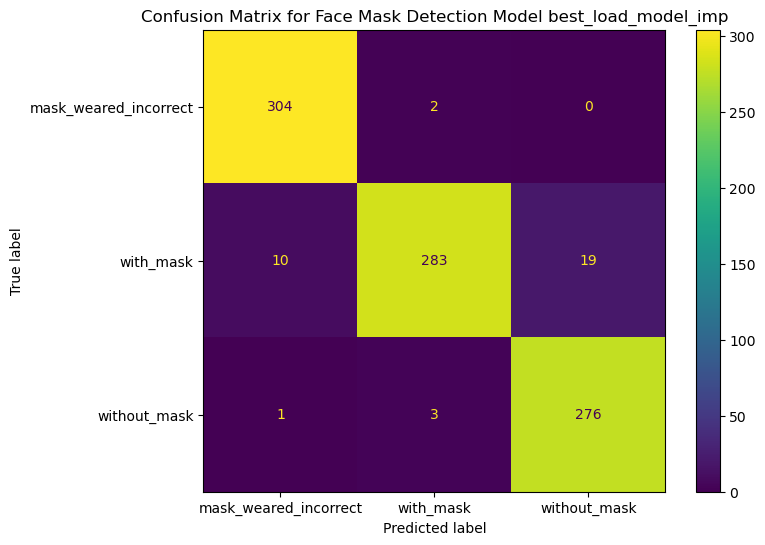

In [92]:
# Calculate confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), best_load_model_imp.predict(X_test).argmax(axis=1))

# Create confusion matrix display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['mask_weared_incorrect', 'with_mask', 'without_mask'])

# Set size and add title to plot
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)
ax.set_title('Confusion Matrix for Face Mask Detection Model best_load_model_imp')

plt.show()

For the 'mask_weared_incorrect' class, the model has correctly classified 304 samples and misclassified only 2 samples as 'with_mask'. For the 'with_mask' class, the model has correctly classified 283 samples and misclassified 12 samples as 'mask_weared_incorrect' and 19 samples as 'without_mask'. For the 'without_mask' class, the model has correctly classified 276 samples and misclassified 4 samples as 'mask_weared_incorrect' and 3 samples as 'with_mask'.

## 7.2 Model Improvement With Aug

In [110]:
checkpoint_filepath_imp_aug = 'best_model_imp_aug.h5'

checkpoint_callback_imp_aug = ModelCheckpoint(
    filepath=checkpoint_filepath_imp_aug,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

Create a callback function that will be triggered during training model. Which saves the weights of the model to a file when the validation loss decreases, ensuring that the best performing version of the model is saved.

### 7.2.1 - Model Definition

In [111]:
# Clear Session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [112]:
input_dim = (128, 128, 3)
num_classes = 3
input_ = Input(shape=input_dim)

flatten_layer = Flatten()(input_)

hidden_layer_1 = Conv2D(64, kernel_size=(2, 2), padding='same', activation='relu')(input_)
hidden_layer_1 = MaxPooling2D(pool_size=(2, 2))(hidden_layer_1)
hidden_layer_1 = BatchNormalization()(hidden_layer_1)

hidden_layer_2 = Conv2D(64, kernel_size=(2, 2), padding='same', activation='relu')(hidden_layer_1)
hidden_layer_2 = MaxPooling2D(pool_size=(2, 2))(hidden_layer_2)
hidden_layer_2 = BatchNormalization()(hidden_layer_2)
hidden_layer_2 = Dropout(0.5)(hidden_layer_2)

dense_layer_1 = Dense(64, activation='relu')(flatten_layer)
dense_layer_2 = Dense(64, activation='relu')(dense_layer_1)
dense_layer_3 = Dense(64, activation='relu')(dense_layer_2)

output_layer = Dense(num_classes, activation='softmax')(dense_layer_3)

model_imp_aug = Model(input_, output_layer)

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)

opt = SGD(lr=0.01, clipnorm=1.0)

model_imp_aug.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['Precision', 'accuracy'])

print(model_imp_aug.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 64)                3145792   
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 3,154,307
Trainable params: 3,154,307
Non-train

This code defines a convolutional neural network model that takes an input image of shape (128, 128, 3) and predicts a probability distribution over 3 classes. The model consists of two convolutional layers with 64 filters, each followed by a max-pooling layer, batch normalization, and dropout. These layers are then connected to three fully connected layers with 64 neurons and ReLU activation. The model is compiled with stochastic gradient descent optimizer with a learning rate of 0.01 and a clipnorm of 1.0, categorical cross-entropy loss function, and evaluation metrics of precision and accuracy.

### 7.2.2 - Model Training

Train model with train_pipe_aug or pipeline with augmentation data.

In [113]:
%%time
# Train the Model
history_imp_aug = model_imp_aug.fit(train_pipe_aug, epochs=120, validation_data=val_pipe, callbacks=[checkpoint_callback_imp_aug])

Epoch 1/120
49/50 [============================>.] - ETA: 0s - loss: 0.9708 - precision: 0.7477 - accuracy: 0.5316
Epoch 1: val_loss improved from inf to 0.82175, saving model to best_model_imp_aug.h5
50/50 [==============================] - 26s 103ms/step - loss: 0.9705 - precision: 0.7477 - accuracy: 0.5316 - val_loss: 0.8217 - val_precision: 0.8869 - val_accuracy: 0.6661
Epoch 2/120
49/50 [============================>.] - ETA: 0s - loss: 0.8332 - precision: 0.7577 - accuracy: 0.6218
Epoch 2: val_loss improved from 0.82175 to 0.79646, saving model to best_model_imp_aug.h5
50/50 [==============================] - 23s 92ms/step - loss: 0.8333 - precision: 0.7575 - accuracy: 0.6221 - val_loss: 0.7965 - val_precision: 0.6843 - val_accuracy: 0.5626
Epoch 3/120
48/50 [===========================>..] - ETA: 0s - loss: 0.7758 - precision: 0.7336 - accuracy: 0.6618
Epoch 3: val_loss improved from 0.79646 to 0.67410, saving model to best_model_imp_aug.h5
50/50 [==============================]

Save the model so that the results do not change when we try to reevaluate the model. Convert trainable params into Non-trainable params and then save the model.

In [128]:
model_imp_aug.trainable = False
model_imp_aug.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 64)                3145792   
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 3,154,307
Trainable params: 0
Non-trainable par

In [132]:
# Save Model
#model_imp_aug.save('load_model_imp_aug.h5')

### 7.2.3 - Model Evaluation

In [114]:
history_imp_aug_df = pd.DataFrame(history_imp_aug.history)
history_imp_aug_df

loss  precision  accuracy  val_loss  val_precision  val_accuracy
0    0.970509   0.747716  0.531573  0.821747       0.886878      0.666110
1    0.833336   0.757480  0.622077  0.796458       0.684257      0.562604
2    0.777187   0.729060  0.659297  0.674099       0.787060      0.688370
3    0.728790   0.759268  0.697789  0.684072       0.772693      0.742905
4    0.709899   0.764334  0.712900  0.678770       0.769380      0.732888
..        ...        ...       ...       ...            ...           ...
115  0.192988   0.937570  0.932877  0.183053       0.940650      0.937117
116  0.202394   0.929856  0.925720  0.175759       0.946749      0.945465
117  0.190048   0.935722  0.929219  0.165225       0.948459      0.945465
118  0.198550   0.930758  0.927628  0.166683       0.949608      0.946578
119  0.198311   0.932669  0.928106  0.158112       0.951151      0.946578

[120 rows x 6 columns]

<AxesSubplot:>

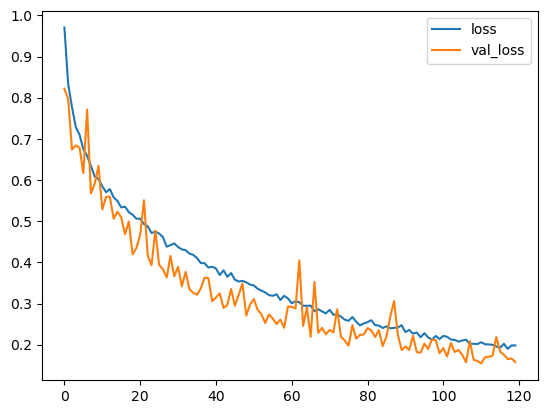

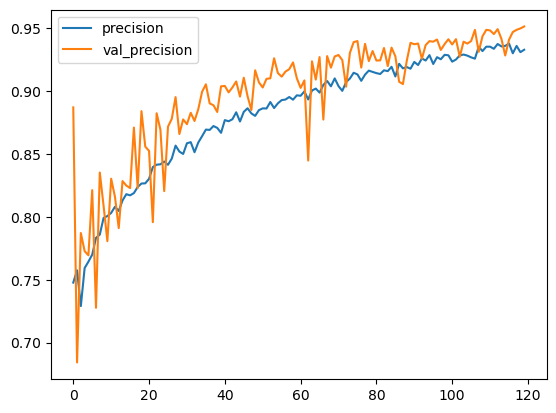

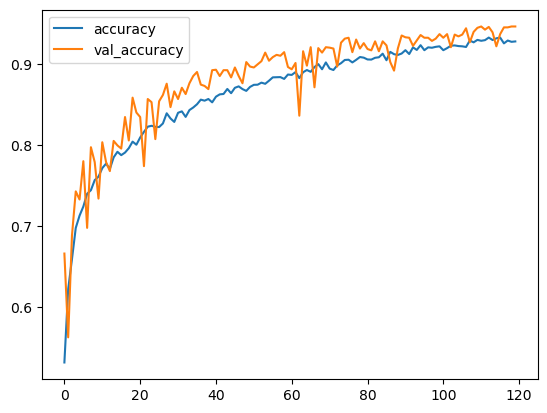

In [115]:
history_imp_aug_df[['loss', 'val_loss']].plot()
history_imp_aug_df[['precision', 'val_precision']].plot()
history_imp_aug_df[['accuracy', 'val_accuracy']].plot()

#### 7.2.3.1 - Evaluation model all epochs

Load model that have been saved with after finishing training

In [54]:
load_model_imp_aug = load_model("load_model_imp_aug.h5")

In [80]:
print(classification_report(y_test.argmax(axis = 1), load_model_imp_aug.predict(X_test).argmax(axis = 1)))
print("")
print("Accuracy score Train-set on load_model_imp_aug : ", accuracy_score(y_train.argmax(axis = 1), load_model_imp_aug.predict(X_train).argmax(axis = 1)))
print("Accuracy score Test-set on load_model_imp_aug : ", accuracy_score(y_test.argmax(axis = 1), load_model_imp_aug.predict(X_test).argmax(axis = 1)))
print("")
print("Precision score Train-set on load_model_imp_aug : ", precision_score(y_train.argmax(axis = 1), load_model_imp_aug.predict(X_train).argmax(axis = 1), average='weighted'))
print("Precision score Test-set on load_model_imp_aug : ", precision_score(y_test.argmax(axis = 1), load_model_imp_aug.predict(X_test).argmax(axis = 1), average='weighted'))
print("")
print("Recall score Train-set on load_model_1 : ", recall_score(y_train.argmax(axis = 1), load_model_imp_aug.predict(X_train).argmax(axis = 1), average='weighted'))
print("Recall score Test-set on load_model_1 : ", recall_score(y_test.argmax(axis = 1), load_model_imp_aug.predict(X_test).argmax(axis = 1), average='weighted'))

29/29 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       306
           1       0.96      0.89      0.92       312
           2       0.93      0.96      0.95       280

    accuracy                           0.94       898
   macro avg       0.94      0.94      0.94       898
weighted avg       0.94      0.94      0.94       898


197/197 [==============================] - 1s 3ms/step
Accuracy score Train-set on load_model_imp_aug :  0.9613488150151105
29/29 [==============================] - 0s 2ms/step
Accuracy score Test-set on load_model_imp_aug :  0.9432071269487751

197/197 [==============================] - 1s 3ms/step
Precision score Train-set on load_model_imp_aug :  0.9615394409503917
29/29 [==============================] - 0s 3ms/step
Precision score Test-set on load_model_imp_aug :  0.9437720934476527

197/197 [==============================] - 1s 3ms/step
Recall score Tra

The accuracy, precision, and recall scores of the model are already quite good, above 94%. However, this model is worse than the model that did not use augmentation.

29/29 [==============================] - 0s 3ms/step


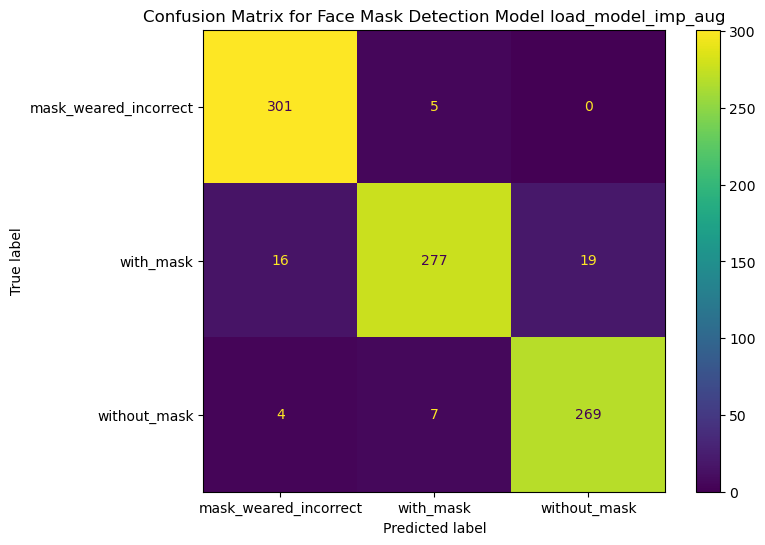

In [97]:
# Calculate confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), load_model_imp_aug.predict(X_test).argmax(axis=1))

# Create confusion matrix display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['mask_weared_incorrect', 'with_mask', 'without_mask'])

# Set size and add title to plot
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)
ax.set_title('Confusion Matrix for Face Mask Detection Model load_model_imp_aug')

plt.show()

For the 'mask_weared_incorrect' class, the model has correctly classified 301 samples and misclassified only 5 samples as 'with_mask'. For the 'with_mask' class, the model has correctly classified 277 samples and misclassified 16 samples as 'mask_weared_incorrect' and 19 samples as 'without_mask'. For the 'without_mask' class, the model has correctly classified 269 samples and misclassified 4 samples as 'mask_weared_incorrect' and 7 samples as 'with_mask'.

#### 7.2.3.2 - Evaluation model callback

Load model that have been saved with callback ModelCheckpoint.

In [94]:
best_load_model_imp_aug = load_model("best_model_imp_aug.h5")

In [95]:
print(classification_report(y_test.argmax(axis = 1), best_load_model_imp_aug.predict(X_test).argmax(axis = 1)))
print("")
print("Accuracy score Train-set on best_load_model_1 : ", accuracy_score(y_train.argmax(axis = 1), best_load_model_imp_aug.predict(X_train).argmax(axis = 1)))
print("Accuracy score Test-set on best_load_model_1 : ", accuracy_score(y_test.argmax(axis = 1), best_load_model_imp_aug.predict(X_test).argmax(axis = 1)))
print("")
print("Precision score Train-set on best_load_model_1 : ", precision_score(y_train.argmax(axis = 1), best_load_model_imp_aug.predict(X_train).argmax(axis = 1), average='weighted'))
print("Precision score Test-set on best_load_model_1 : ", precision_score(y_test.argmax(axis = 1), best_load_model_imp_aug.predict(X_test).argmax(axis = 1), average='weighted'))
print("")
print("Recall score Train-set on load_model_1 : ", recall_score(y_train.argmax(axis = 1), best_load_model_imp_aug.predict(X_train).argmax(axis = 1), average='weighted'))
print("Recall score Test-set on load_model_1 : ", recall_score(y_test.argmax(axis = 1), best_load_model_imp_aug.predict(X_test).argmax(axis = 1), average='weighted'))

29/29 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       306
           1       0.97      0.85      0.91       312
           2       0.92      0.95      0.93       280

    accuracy                           0.93       898
   macro avg       0.93      0.93      0.93       898
weighted avg       0.93      0.93      0.93       898


197/197 [==============================] - 1s 3ms/step
Accuracy score Train-set on best_load_model_1 :  0.9551455384125974
29/29 [==============================] - 0s 3ms/step
Accuracy score Test-set on best_load_model_1 :  0.9309576837416481

197/197 [==============================] - 1s 3ms/step
Precision score Train-set on best_load_model_1 :  0.9558694681748321
29/29 [==============================] - 0s 3ms/step
Precision score Test-set on best_load_model_1 :  0.9338754762404994

197/197 [==============================] - 1s 3ms/step
Recall score Train-s

An important finding is that the model performs worse when used on the test set. This suggests that the model may have overfit to the training set and may not generalize well to new, unseen data. It is important to address this issue by adjusting the model architecture or using techniques such as regularization to prevent overfitting. Additionally, evaluating a model's performance on a separate test set is crucial to assess its real-world effectiveness and avoid overestimating its performance.

29/29 [==============================] - 0s 3ms/step


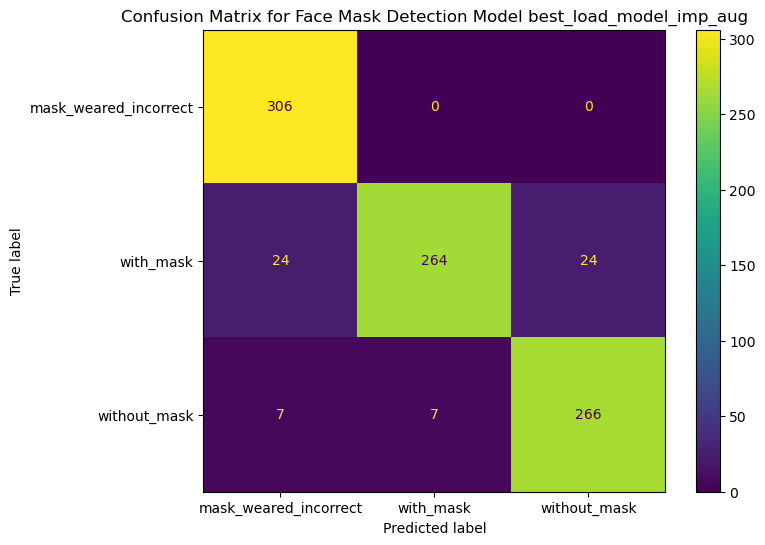

In [96]:
# Calculate confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), best_load_model_imp_aug.predict(X_test).argmax(axis=1))

# Create confusion matrix display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['mask_weared_incorrect', 'with_mask', 'without_mask'])

# Set size and add title to plot
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)
ax.set_title('Confusion Matrix for Face Mask Detection Model best_load_model_imp_aug')

plt.show()

For the 'mask_weared_incorrect' class, the model has correctly classified all samples. For the 'with_mask' class, the model has correctly classified 264 samples and misclassified 24 samples as 'mask_weared_incorrect' and 24 samples as 'without_mask'. For the 'without_mask' class, the model has correctly classified 266 samples and misclassified 7 samples as 'mask_weared_incorrect' and 7 samples as 'with_mask'.

# 8 - Analysis Model 📊

In [ ]:
load_model_1_dict = {
    "Train - Accuracy" : accuracy_score(y_train.argmax(axis = 1), load_model_1.predict(X_train).argmax(axis = 1)),
    "Test - Accuracy" : accuracy_score(y_test.argmax(axis = 1), load_model_1.predict(X_test).argmax(axis = 1)),
    "Train - Precision" : precision_score(y_train.argmax(axis = 1), load_model_1.predict(X_train).argmax(axis = 1), average='weighted'),
    "Test - Precision" : precision_score(y_test.argmax(axis = 1), load_model_1.predict(X_test).argmax(axis = 1), average='weighted'),
    "Train - Recall" : recall_score(y_train.argmax(axis = 1), load_model_1.predict(X_train).argmax(axis = 1), average='weighted'),
    "Test - Recall" : recall_score(y_test.argmax(axis = 1), load_model_1.predict(X_test).argmax(axis = 1), average='weighted')}
best_load_model_1_dict = {
    "Train - Accuracy" : accuracy_score(y_train.argmax(axis = 1), best_load_model_1.predict(X_train).argmax(axis = 1)),
    "Test - Accuracy" : accuracy_score(y_test.argmax(axis = 1), best_load_model_1.predict(X_test).argmax(axis = 1)),
    "Train - Precision" : precision_score(y_train.argmax(axis = 1), best_load_model_1.predict(X_train).argmax(axis = 1), average='weighted'),
    "Test - Precision" : precision_score(y_test.argmax(axis = 1), best_load_model_1.predict(X_test).argmax(axis = 1), average='weighted'),
    "Train - Recall" : recall_score(y_train.argmax(axis = 1), best_load_model_1.predict(X_train).argmax(axis = 1), average='weighted'),
    "Test - Recall" : recall_score(y_test.argmax(axis = 1), best_load_model_1.predict(X_test).argmax(axis = 1), average='weighted')}
load_model_1_aug_dict = {
    "Train - Accuracy" : accuracy_score(y_train.argmax(axis = 1), load_model_1_aug.predict(X_train).argmax(axis = 1)),
    "Test - Accuracy" : accuracy_score(y_test.argmax(axis = 1), load_model_1_aug.predict(X_test).argmax(axis = 1)),
    "Train - Precision" : precision_score(y_train.argmax(axis = 1), load_model_1_aug.predict(X_train).argmax(axis = 1), average='weighted'),
    "Test - Precision" : precision_score(y_test.argmax(axis = 1), load_model_1_aug.predict(X_test).argmax(axis = 1), average='weighted'),
    "Train - Recall" : recall_score(y_train.argmax(axis = 1), load_model_1_aug.predict(X_train).argmax(axis = 1), average='weighted'),
    "Test - Recall" : recall_score(y_test.argmax(axis = 1), load_model_1_aug.predict(X_test).argmax(axis = 1), average='weighted')}
best_load_model_1_aug_dict = {
    "Train - Accuracy" : accuracy_score(y_train.argmax(axis = 1), best_load_model_1_aug.predict(X_train).argmax(axis = 1)),
    "Test - Accuracy" : accuracy_score(y_test.argmax(axis = 1), best_load_model_1_aug.predict(X_test).argmax(axis = 1)),
    "Train - Precision" : precision_score(y_train.argmax(axis = 1), best_load_model_1_aug.predict(X_train).argmax(axis = 1), average='weighted'),
    "Test - Precision" : precision_score(y_test.argmax(axis = 1), best_load_model_1_aug.predict(X_test).argmax(axis = 1), average='weighted'),
    "Train - Recall" : recall_score(y_train.argmax(axis = 1), best_load_model_1_aug.predict(X_train).argmax(axis = 1), average='weighted'),
    "Test - Recall" : recall_score(y_test.argmax(axis = 1), best_load_model_1_aug.predict(X_test).argmax(axis = 1), average='weighted')}
load_model_imp_dict = {
    "Train - Accuracy" : accuracy_score(y_train.argmax(axis = 1), load_model_imp.predict(X_train).argmax(axis = 1)),
    "Test - Accuracy" : accuracy_score(y_test.argmax(axis = 1), load_model_imp.predict(X_test).argmax(axis = 1)),
    "Train - Precision" : precision_score(y_train.argmax(axis = 1), load_model_imp.predict(X_train).argmax(axis = 1), average='weighted'),
    "Test - Precision" : precision_score(y_test.argmax(axis = 1), load_model_imp.predict(X_test).argmax(axis = 1), average='weighted'),
    "Train - Recall" : recall_score(y_train.argmax(axis = 1), load_model_imp.predict(X_train).argmax(axis = 1), average='weighted'),
    "Test - Recall" : recall_score(y_test.argmax(axis = 1), load_model_imp.predict(X_test).argmax(axis = 1), average='weighted')}
best_load_model_imp_dict = {
    "Train - Accuracy" : accuracy_score(y_train.argmax(axis = 1), best_load_model_imp.predict(X_train).argmax(axis = 1)),
    "Test - Accuracy" : accuracy_score(y_test.argmax(axis = 1), best_load_model_imp.predict(X_test).argmax(axis = 1)),
    "Train - Precision" : precision_score(y_train.argmax(axis = 1), best_load_model_imp.predict(X_train).argmax(axis = 1), average='weighted'),
    "Test - Precision" : precision_score(y_test.argmax(axis = 1), best_load_model_imp.predict(X_test).argmax(axis = 1), average='weighted'),
    "Train - Recall" : recall_score(y_train.argmax(axis = 1), best_load_model_imp.predict(X_train).argmax(axis = 1), average='weighted'),
    "Test - Recall" : recall_score(y_test.argmax(axis = 1), best_load_model_imp.predict(X_test).argmax(axis = 1), average='weighted')}
load_model_imp_aug_dict = {
    "Train - Accuracy" : accuracy_score(y_train.argmax(axis = 1), load_model_imp_aug.predict(X_train).argmax(axis = 1)),
    "Test - Accuracy" : accuracy_score(y_test.argmax(axis = 1), load_model_imp_aug.predict(X_test).argmax(axis = 1)),
    "Train - Precision" : precision_score(y_train.argmax(axis = 1), load_model_imp_aug.predict(X_train).argmax(axis = 1), average='weighted'),
    "Test - Precision" : precision_score(y_test.argmax(axis = 1), load_model_imp_aug.predict(X_test).argmax(axis = 1), average='weighted'),
    "Train - Recall" : recall_score(y_train.argmax(axis = 1), load_model_imp_aug.predict(X_train).argmax(axis = 1), average='weighted'),
    "Test - Recall" : recall_score(y_test.argmax(axis = 1), load_model_imp_aug.predict(X_test).argmax(axis = 1), average='weighted')}
best_load_model_imp_aug_dict = {
    "Train - Accuracy" : accuracy_score(y_train.argmax(axis = 1), best_load_model_imp_aug.predict(X_train).argmax(axis = 1)),
    "Test - Accuracy" : accuracy_score(y_test.argmax(axis = 1), best_load_model_imp_aug.predict(X_test).argmax(axis = 1)),
    "Train - Precision" : precision_score(y_train.argmax(axis = 1), best_load_model_imp_aug.predict(X_train).argmax(axis = 1), average='weighted'),
    "Test - Precision" : precision_score(y_test.argmax(axis = 1), best_load_model_imp_aug.predict(X_test).argmax(axis = 1), average='weighted'),
    "Train - Recall" : recall_score(y_train.argmax(axis = 1), best_load_model_imp_aug.predict(X_train).argmax(axis = 1), average='weighted'),
    "Test - Recall" : recall_score(y_test.argmax(axis = 1), best_load_model_imp_aug.predict(X_test).argmax(axis = 1), average='weighted')}

In [103]:
all_reports ={}
all_reports['model_1'] = load_model_1_dict
all_reports['best_model_1'] = best_load_model_1_dict
all_reports['model_1_aug'] = load_model_1_aug_dict
all_reports['best_model_1_aug'] = best_load_model_1_aug_dict
all_reports['model_imp'] = load_model_imp_dict
all_reports['best_model_imp'] = best_load_model_imp_dict
all_reports['model_imp_aug'] = load_model_imp_aug_dict
all_reports['best_model_imp_aug'] = best_load_model_imp_aug_dict
report = pd.DataFrame(all_reports)
report = report.transpose()
report = report.sort_values(by='Test - Accuracy', ascending=False)
report

Train - Accuracy  Test - Accuracy  Train - Precision  \
best_model_imp              0.996183         0.961024           0.996208   
best_model_1                0.990616         0.957684           0.990668   
model_imp                   0.994592         0.957684           0.994612   
model_1                     0.989025         0.953229           0.989026   
best_model_1_aug            0.964848         0.945434           0.965893   
model_imp_aug               0.961349         0.943207           0.961539   
model_1_aug                 0.948465         0.942094           0.948925   
best_model_imp_aug          0.955146         0.930958           0.955869   

                    Test - Precision  Train - Recall  Test - Recall  
best_model_imp              0.961986        0.996183       0.961024  
best_model_1                0.958523        0.990616       0.957684  
model_imp                   0.958505        0.994592       0.957684  
model_1                     0.954106        0.989025       0.953229  
best_model_1_aug            0.948409        0.964848       0.945434  
model_imp_aug               0.943772        0.961349       0.943207  
model_1_aug                 0.944035        0.948465       0.942094  
best_model_imp_aug          0.933875        0.955146       0.930958

To analyze this model I use 3 metrics for calculate performance of the model. The metrics used are accuracy, precision, and recall, which are commonly used to evaluate the performance of classification models.

The best performing model, best_model_imp, achieved a train accuracy of 0.996183 and a test accuracy of 0.961024. This model also achieved a train precision of 0.996208 and a test precision of 0.961986, indicating a high level of accuracy in correctly identifying the different classes. Additionally, the model had a train and test recall score of 0.996183 and 0.961024, respectively, demonstrating that it could effectively identify the different classes in the face images.

In comparison, some of the other models did not perform as well, with lower accuracy, precision, and recall scores. For example, the model_best_imp_aug had a train accuracy of 0.955146 and a test accuracy of 0.930958, indicating that it did not perform as well as the best_model_imp. Similarly, the model_best_model_1_aug had the lowest test accuracy score of all the models with a score of 0.945434.

The results of this analysis suggest that the best_model_imp could be considered the most reliable model for detecting face masks in real-world scenarios, where high levels of accuracy are crucial. So best_model_imp got choose as the best model. However, the other models' results suggest that ongoing refinement and optimization are necessary to improve the accuracy, precision, and recall scores of machine learning models. This study highlights the importance of continually improving the performance of machine learning models to achieve more accurate and reliable results.

## 8.1 - Analyze wrong prediction

In [114]:
y_true = y_test.argmax(axis=1)
y_pred = best_load_model_imp.predict(X_test).argmax(axis=1)

label_names = ["mask_weared_incorrect", "with_mask", "without_mask"]

# set random state for reproducibility
np.random.seed(42)
random.seed(42)

# get indices of misclassified images
misclassified_indices = np.where(y_pred != y_true)[0]

# select 5 random misclassified images
random_misclassified_indices = random.sample(list(misclassified_indices), k=5)

print("Incorrectly classified indices:", random_misclassified_indices)

29/29 [==============================] - 0s 3ms/step
Incorrectly classified indices: [314, 60, 479, 457, 453]


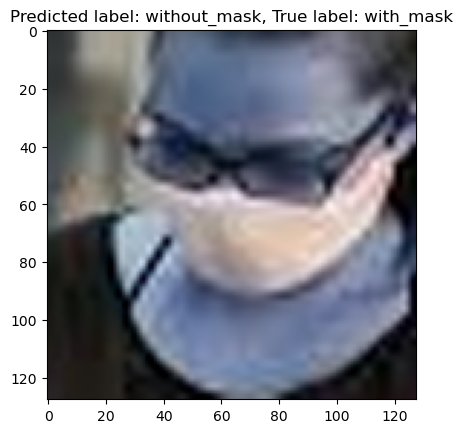

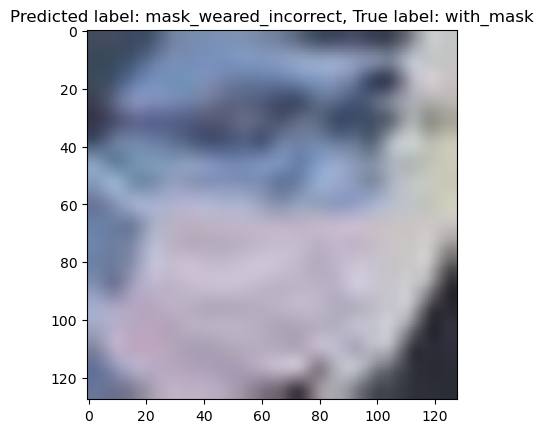

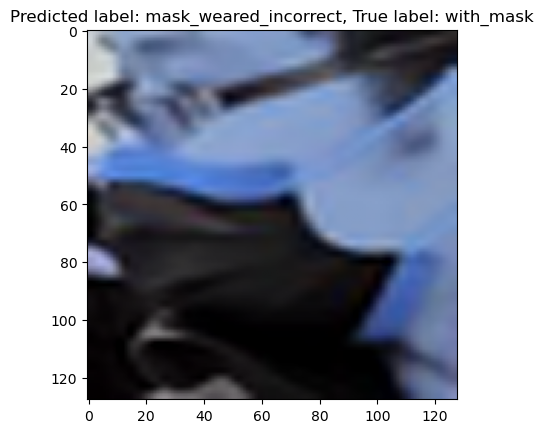

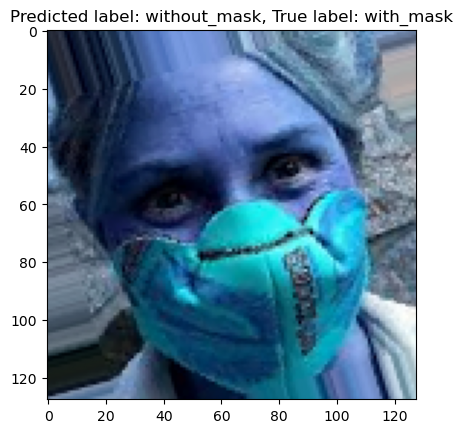

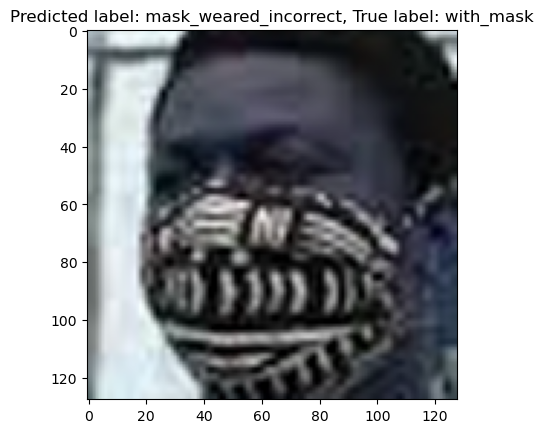

In [116]:
for idx in random_misclassified_indices:
    plt.imshow(X_test[idx])
    plt.title(f"Predicted label: {label_names[y_pred[idx]]}, True label: {label_names[y_true[idx]]}")
    plt.show()

There are several reasons why the detection mask model might have misclassified some of the images. The first, third, and fifth images were classified as wrong due to the poor angle or unique pattern and texture of the mask. The second image was misclassified because the image was blurry and unclear. Lastly, the fourth image was misclassified due to the unique shape of the mask, which was different from the standard medical masks used in the training dataset. These insights indicate that for the detection mask model to improve its accuracy, it needs to be trained with more diverse and representative datasets that can handle various angles, patterns, textures, and shapes of masks.

# 9 - Model Saving💾

The model saving has been performed during the model training.

# 10 - Model Inference📱

## 10.1 - Load Model

In [104]:
# Define the label names for the classes
label_names = ["mask_weared_incorrect", "with_mask", "without_mask"]

# Load the trained model
model = tf.keras.models.load_model("best_model_imp.h5")

## 10.2 - Data Loading

In [105]:
image_filenames = ["test_1.png", "test_2.png", "test_3.png",
                    "test_4.png", "test_5.png", "test_6.png", "test_7.png"]

## 10.3 - Inferencing

1/1 [==============================] - 0s 48ms/step


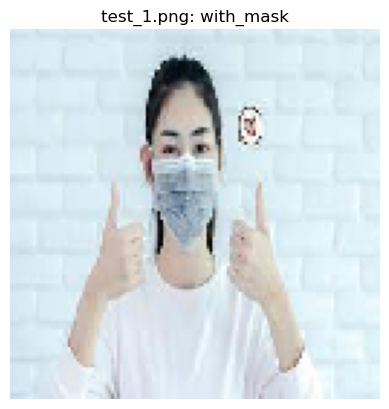

Predicted class for test_1.png: with_mask
1/1 [==============================] - 0s 16ms/step


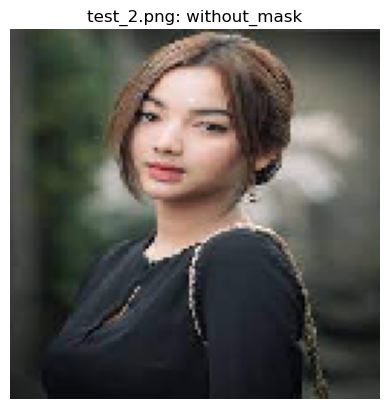

Predicted class for test_2.png: without_mask
1/1 [==============================] - 0s 14ms/step


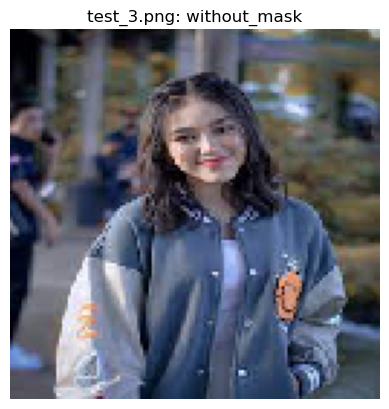

Predicted class for test_3.png: without_mask
1/1 [==============================] - 0s 17ms/step


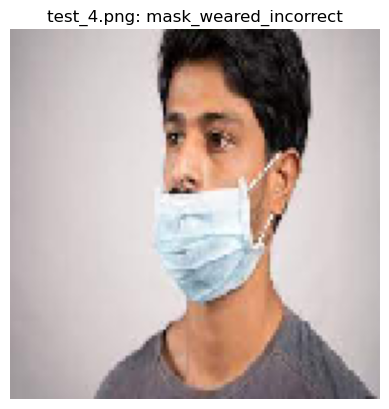

Predicted class for test_4.png: mask_weared_incorrect
1/1 [==============================] - 0s 14ms/step


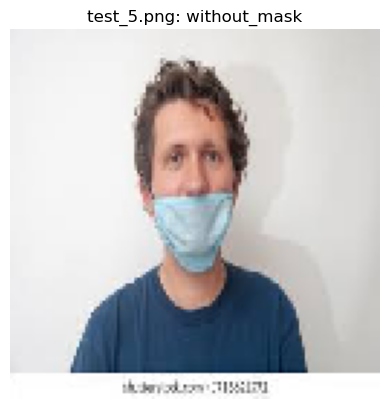

Predicted class for test_5.png: without_mask
1/1 [==============================] - 0s 16ms/step


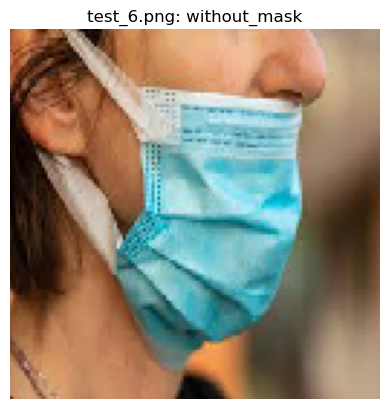

Predicted class for test_6.png: without_mask
1/1 [==============================] - 0s 22ms/step


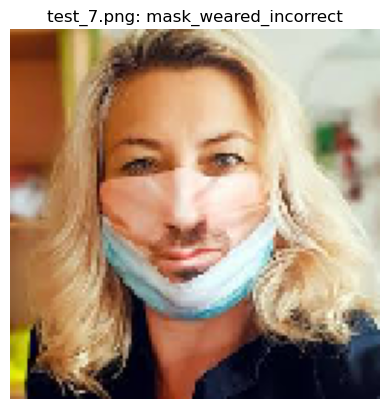

Predicted class for test_7.png: mask_weared_incorrect


In [106]:
for image_filename in image_filenames:
    # Load the image using TensorFlow
    img = tf.keras.utils.load_img(image_filename, target_size=(128, 128, 3))
    
    # Convert the PIL.Image.Image object to a NumPy array
    x = tf.keras.utils.img_to_array(img)
    
    # Expand the array to add a batch dimension
    x = np.expand_dims(x, axis=0)
    
    # Normalize the image data
    x = x / 255.0
    
    # Make the prediction using the loaded model
    y_pred = model.predict(x)
    
    # Get the index of the predicted class with the highest probability
    class_idx = np.argmax(y_pred, axis=1)[0]

    # Show the image along with the predicted class label
    plt.imshow(img)
    plt.title(f"{image_filename}: {label_names[class_idx]}")
    plt.axis('off')
    plt.show()

    # Print the predicted class label for the image
    print(f"Predicted class for {image_filename}: {label_names[class_idx]}")

## 10.4 - Insight

For test images 1, 2, and 3, the model was able to detect the correct usage of masks in each image. However, for test images 5 and 6, the model failed to detect that the person in the image was not wearing a mask, and in test image 7, the model incorrectly classified the person as not wearing a mask. This indicates that the model's performance in detecting mask usage may be inconsistent, and further improvements may be needed to increase its accuracy.

# 11 - Conclusions🖋️

Conclusion:

- The EDA indicates that the face mask detection dataset is well-balanced across all classes with each class containing 2994 data points. Additionally, the dataset contains colored images of size (128,128,3), which suggests that the model needs to consider color information to accurately classify whether a person is wearing a face mask or not. These insights are important for developing a robust face mask detection model that can generalize well to real-world scenarios.

- The evaluation of 8 models for face mask detection revealed that the best_model_imp was the best performing model. This model had a Test-accuracy score of 0.961024, Test-precision score of 0.961986, and Test-recall score of 0.961024. And beacuse the Test-precision score of model is 0.961986, This means that the model is highly accurate and precise, and has the potential to correctly predict the mask-wearing status of 96 out of 100 people.

- the model has some weaknesses observed during model inference, such as the inability to detect blurry images and unique or patterned masks that were not present in the train set. These limitations can be seen in Model Inference.

- Based on the insight that the model has weaknesses in detecting blurry images and unique or patterned masks, a suggestion to improve the model is to incorporate more diverse and representative datasets during training. This can help the model better handle various angles, patterns, textures, and shapes of masks, and potentially improve its accuracy in detecting masks in real-world scenarios.